# Practical Application III: Comparing Classifiers

**Overview**: In this practical application, your goal is to compare the performance of the classifiers we encountered in this section, namely K Nearest Neighbor, Logistic Regression, Decision Trees, and Support Vector Machines.  We will utilize a dataset related to marketing bank products over the telephone.  



## Getting Started

Our dataset comes from the UCI Machine Learning repository [link](https://archive.ics.uci.edu/ml/datasets/bank+marketing).  The data is from a Portugese banking institution and is a collection of the results of multiple marketing campaigns.  We will make use of the article accompanying the dataset [here](../data/CRISP-DM-BANK.pdf) for more information on the data and features.



## **Problem 1: Understanding the Data**

To gain a better understanding of the data, please read the information provided in the UCI link above, and examine the **Materials and Methods** section of the paper.  How many marketing campaigns does this data represent?

*The "Materials and Methods" section of the provided PDF document indicates that the data collected is related to 17 marketing campaigns. These campaigns occurred between May 2008 and November 2010, resulting in a total of 79,354 contacts​.*

## **Problem 2: Read in the Data**

Use pandas to read in the dataset `bank-additional-full.csv` and assign to a meaningful variable name.

In [1]:
!pip install --quiet --upgrade pandas numpy scikit-learn matplotlib seaborn xgboost imbalanced-learn

import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix, RocCurveDisplay, PrecisionRecallDisplay, f1_score, precision_score, recall_score
from sklearn.preprocessing import StandardScaler, OneHotEncoder, LabelEncoder, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.inspection import permutation_importance
from imblearn.over_sampling import SMOTE
from scipy.stats import boxcox

# Adjust Pandas settings to display all columns and avoid truncation
pd.set_option('display.max_columns', None)  # Show all columns
pd.set_option('display.max_rows', None)  # Show all rows (if needed)
pd.set_option('display.max_colwidth', None)  # Show full content of each column
pd.set_option('display.width', None)  # Automatically adjust the display width


[notice] A new release of pip is available: 24.0 -> 24.1.2
[notice] To update, run: pip install --upgrade pip


In [2]:
df = pd.read_csv('../data/bank-additional-full.csv', sep = ';')

In [3]:
df.sample(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
17674,39,admin.,divorced,high.school,no,no,no,telephone,jul,mon,210,3,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
1776,60,technician,divorced,professional.course,unknown,yes,no,telephone,may,fri,57,2,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
23276,43,admin.,married,university.degree,no,yes,no,cellular,aug,wed,281,4,999,0,nonexistent,1.4,93.444,-36.1,4.964,5228.1,no
36483,28,admin.,single,high.school,no,no,no,cellular,jun,wed,198,1,999,0,nonexistent,-2.9,92.963,-40.8,1.260,5076.2,yes
32238,33,admin.,single,high.school,no,no,yes,cellular,may,fri,93,1,999,0,nonexistent,-1.8,92.893,-46.2,1.313,5099.1,no
30483,27,student,single,high.school,no,no,no,cellular,may,mon,64,2,999,1,failure,-1.8,92.893,-46.2,1.354,5099.1,no
11279,43,blue-collar,divorced,basic.9y,unknown,no,no,telephone,jun,thu,409,1,999,0,nonexistent,1.4,94.465,-41.8,4.961,5228.1,no
16802,27,management,single,university.degree,no,no,no,cellular,jul,thu,528,1,999,0,nonexistent,1.4,93.918,-42.7,4.962,5228.1,no
32762,31,services,single,high.school,no,yes,no,cellular,may,mon,151,2,999,1,failure,-1.8,92.893,-46.2,1.299,5099.1,no
23158,57,retired,married,basic.9y,no,yes,yes,cellular,aug,tue,1223,4,999,0,nonexistent,1.4,93.444,-36.1,4.965,5228.1,yes


In [4]:
df.shape

(41188, 21)

## **Problem 3: Understanding the Features**


Examine the data description below, and determine if any of the features are missing values or need to be coerced to a different data type.


```
Input variables:
# bank client data:
1 - age (numeric)
2 - job : type of job (categorical: 'admin.','blue-collar','entrepreneur','housemaid','management','retired','self-employed','services','student','technician','unemployed','unknown')
3 - marital : marital status (categorical: 'divorced','married','single','unknown'; note: 'divorced' means divorced or widowed)
4 - education (categorical: 'basic.4y','basic.6y','basic.9y','high.school','illiterate','professional.course','university.degree','unknown')
5 - default: has credit in default? (categorical: 'no','yes','unknown')
6 - housing: has housing loan? (categorical: 'no','yes','unknown')
7 - loan: has personal loan? (categorical: 'no','yes','unknown')
# related with the last contact of the current campaign:
8 - contact: contact communication type (categorical: 'cellular','telephone')
9 - month: last contact month of year (categorical: 'jan', 'feb', 'mar', ..., 'nov', 'dec')
10 - day_of_week: last contact day of the week (categorical: 'mon','tue','wed','thu','fri')
11 - duration: last contact duration, in seconds (numeric). Important note: this attribute highly affects the output target (e.g., if duration=0 then y='no'). Yet, the duration is not known before a call is performed. Also, after the end of the call y is obviously known. Thus, this input should only be included for benchmark purposes and should be discarded if the intention is to have a realistic predictive model.
# other attributes:
12 - campaign: number of contacts performed during this campaign and for this client (numeric, includes last contact)
13 - pdays: number of days that passed by after the client was last contacted from a previous campaign (numeric; 999 means client was not previously contacted)
14 - previous: number of contacts performed before this campaign and for this client (numeric)
15 - poutcome: outcome of the previous marketing campaign (categorical: 'failure','nonexistent','success')
# social and economic context attributes
16 - emp.var.rate: employment variation rate - quarterly indicator (numeric)
17 - cons.price.idx: consumer price index - monthly indicator (numeric)
18 - cons.conf.idx: consumer confidence index - monthly indicator (numeric)
19 - euribor3m: euribor 3 month rate - daily indicator (numeric)
20 - nr.employed: number of employees - quarterly indicator (numeric)

Output variable (desired target):
21 - y - has the client subscribed a term deposit? (binary: 'yes','no')
```



In [5]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 41188 entries, 0 to 41187
Data columns (total 21 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   age             41188 non-null  int64  
 1   job             41188 non-null  object 
 2   marital         41188 non-null  object 
 3   education       41188 non-null  object 
 4   default         41188 non-null  object 
 5   housing         41188 non-null  object 
 6   loan            41188 non-null  object 
 7   contact         41188 non-null  object 
 8   month           41188 non-null  object 
 9   day_of_week     41188 non-null  object 
 10  duration        41188 non-null  int64  
 11  campaign        41188 non-null  int64  
 12  pdays           41188 non-null  int64  
 13  previous        41188 non-null  int64  
 14  poutcome        41188 non-null  object 
 15  emp.var.rate    41188 non-null  float64
 16  cons.price.idx  41188 non-null  float64
 17  cons.conf.idx   41188 non-null 

### **Drop Duplicates**

In [6]:
df_cleaned = df.drop_duplicates()
df_cleaned.shape

(41176, 21)

The purpose of dropping duplicates is to ensure that each entry in the dataset is unique, which prevents redundant data from skewing analysis or models. This process helps improve the accuracy and reliability of data insights and reduces computational overhead.

### **Examine Cardinality of Categorical Features**

In [7]:
# Check cardinality of categorical columns
categorical_features = df_cleaned.select_dtypes(include=['object']).columns
for column in categorical_features:
    print(f'Column: {column}, Unique value count: {df_cleaned[column].nunique()}')

Column: job, Unique value count: 12
Column: marital, Unique value count: 4
Column: education, Unique value count: 8
Column: default, Unique value count: 3
Column: housing, Unique value count: 3
Column: loan, Unique value count: 3
Column: contact, Unique value count: 2
Column: month, Unique value count: 10
Column: day_of_week, Unique value count: 5
Column: poutcome, Unique value count: 3
Column: y, Unique value count: 2


Examining unique value counts in the dataset helps identify the cardinality of categorical columns, which is the number of distinct values each column contains. This information is crucial for understanding the complexity of the dataset, identifying potential issues such as high cardinality that might require special handling, and ensuring appropriate preprocessing steps are applied.

### **Review the `unique values` in each Categorical Feature**

In [8]:
# Loop through each column and print the unique values
for column in categorical_features:
    print(f"\nUnique values in '{column}':\n{df_cleaned[column].unique()}")


Unique values in 'job':
['housemaid' 'services' 'admin.' 'blue-collar' 'technician' 'retired'
 'management' 'unemployed' 'self-employed' 'unknown' 'entrepreneur'
 'student']

Unique values in 'marital':
['married' 'single' 'divorced' 'unknown']

Unique values in 'education':
['basic.4y' 'high.school' 'basic.6y' 'basic.9y' 'professional.course'
 'unknown' 'university.degree' 'illiterate']

Unique values in 'default':
['no' 'unknown' 'yes']

Unique values in 'housing':
['no' 'yes' 'unknown']

Unique values in 'loan':
['no' 'yes' 'unknown']

Unique values in 'contact':
['telephone' 'cellular']

Unique values in 'month':
['may' 'jun' 'jul' 'aug' 'oct' 'nov' 'dec' 'mar' 'apr' 'sep']

Unique values in 'day_of_week':
['mon' 'tue' 'wed' 'thu' 'fri']

Unique values in 'poutcome':
['nonexistent' 'failure' 'success']

Unique values in 'y':
['no' 'yes']


Reviewing the unique values in each categorical variable is crucial for understanding data distribution, detecting and handling missing values, and informing preprocessing steps. Unique values reveal the range of categories within each feature, helping to identify potential issues such as 'unknown' values that may represent missing or ambiguous data. This knowledge guides decisions on whether to impute, drop, or treat 'unknown' as a separate category. Additionally, understanding unique values helps in choosing appropriate encoding strategies (e.g., one-hot encoding for nominal categories, label encoding for ordinal categories) and informs feature engineering. Overall, this review ensures accurate, meaningful data transformations and improves model performance by providing insights into the data's structure and quality.

### **Visualize the distribution of the categorical features to understand their distributions and the prevalence of `unknown` values**

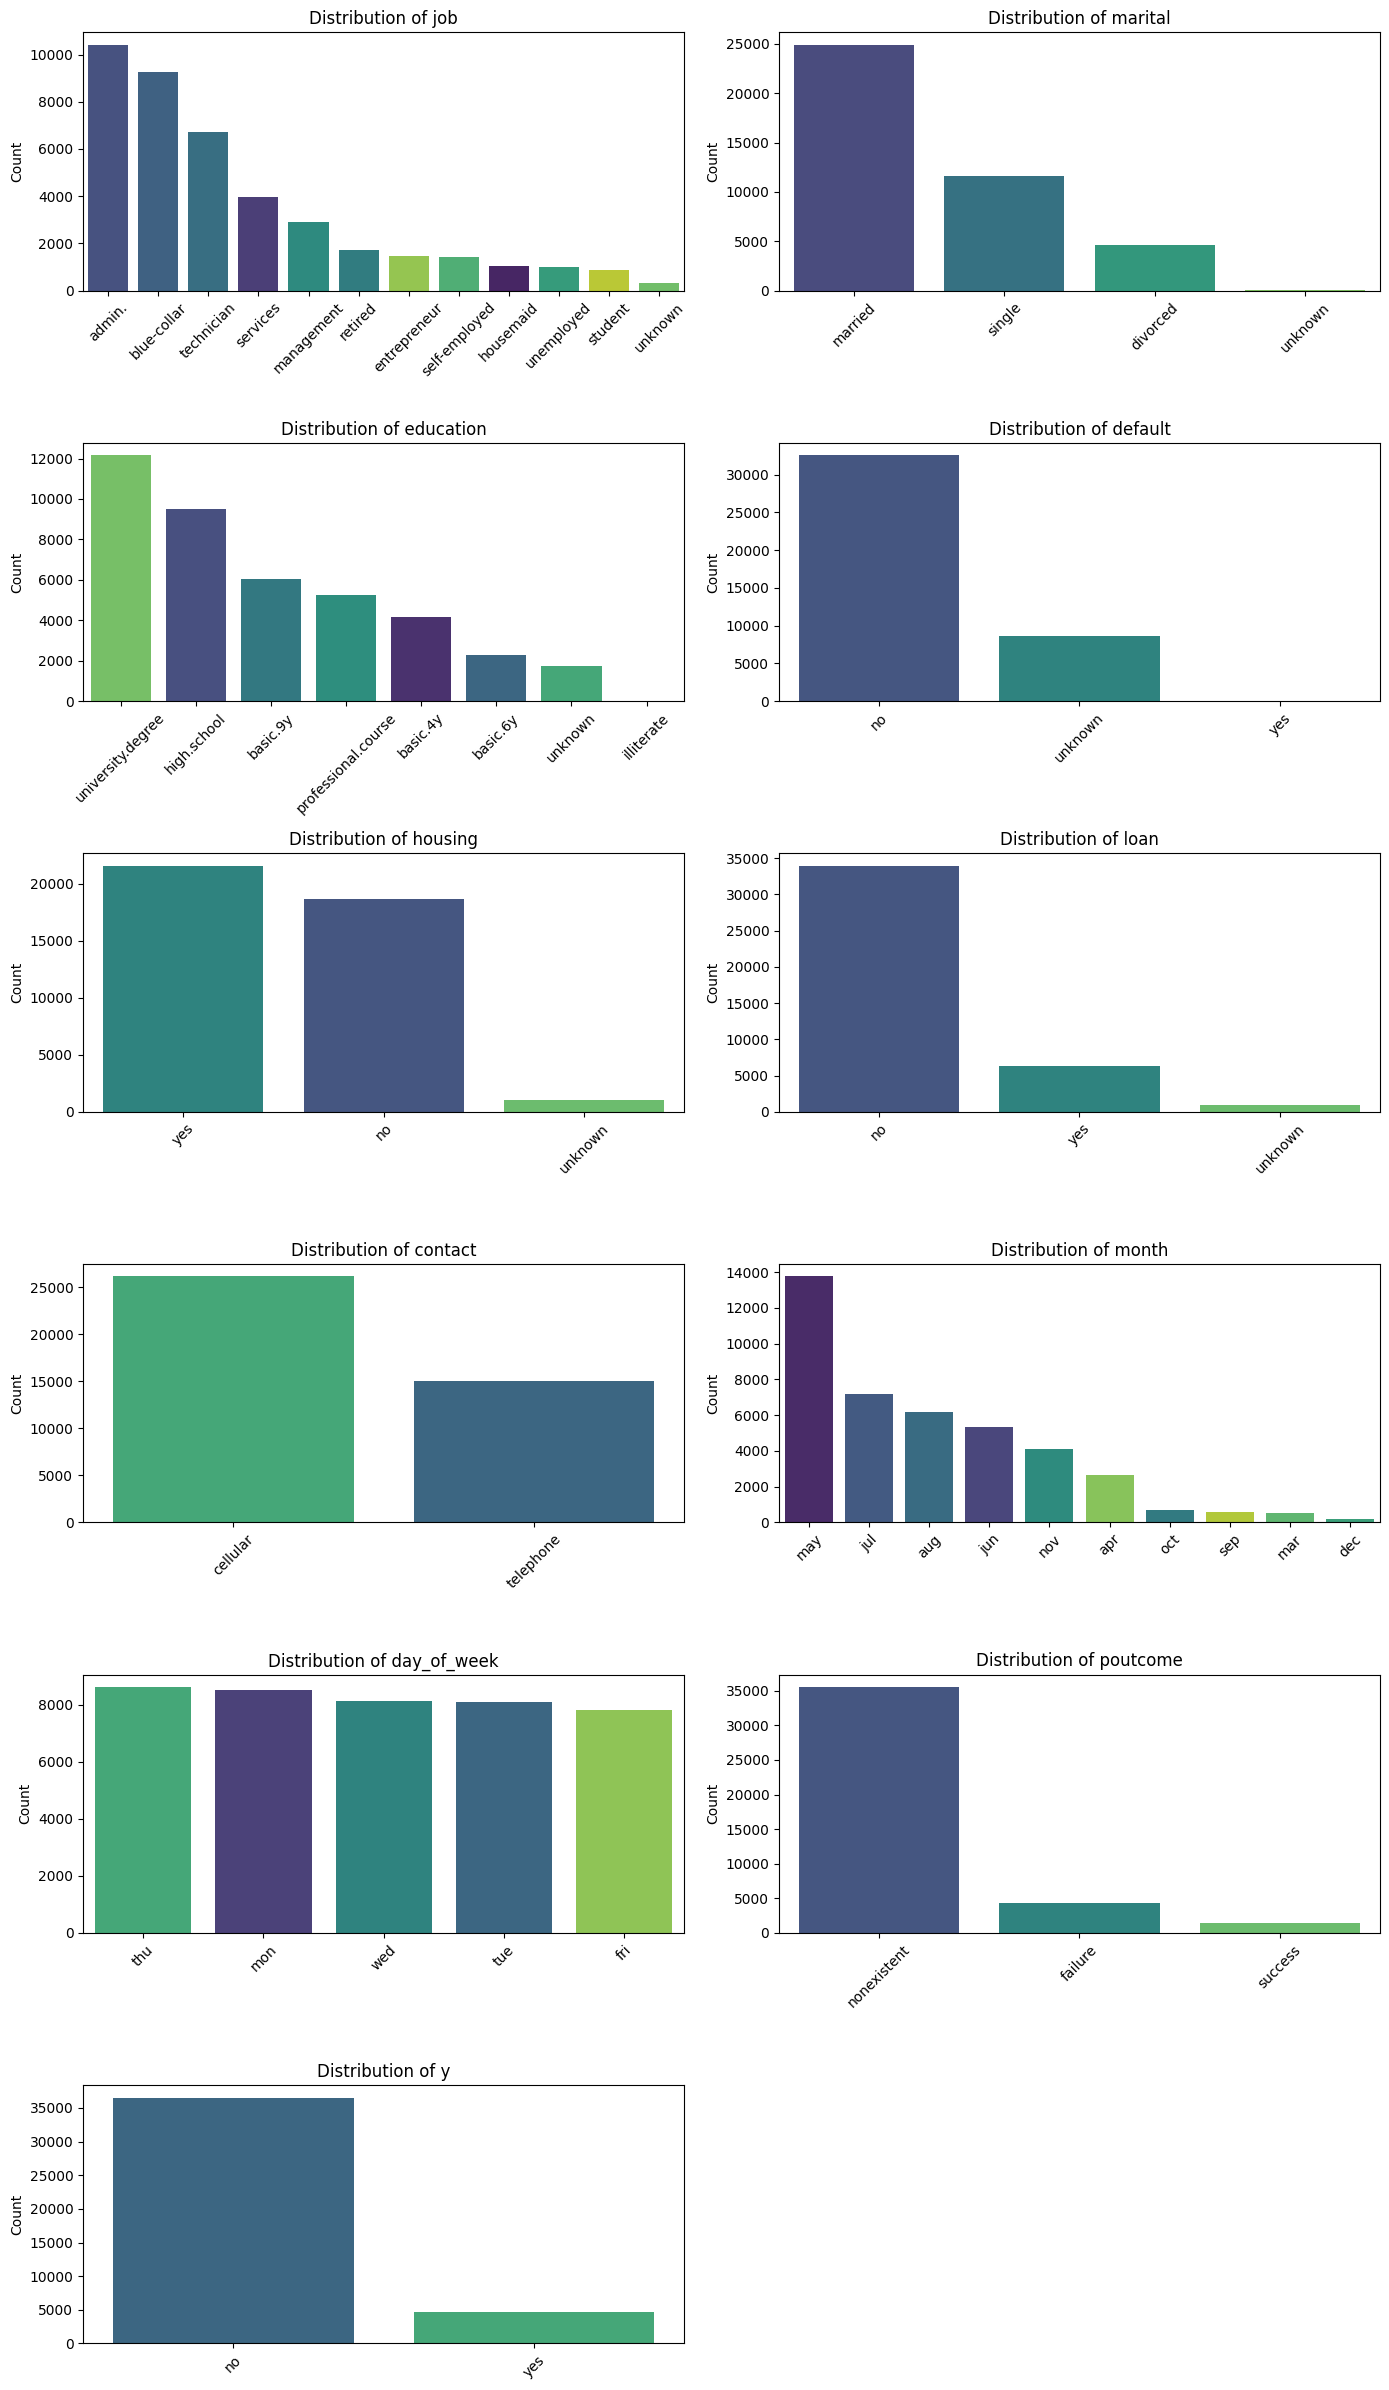

In [9]:
# Function to plot data distribution for categorical features
def plot_categorical_distribution(df, categorical_features):
    n_features = len(categorical_features)
    n_cols = 2
    n_rows = (n_features + 1) // n_cols

    plt.figure(figsize=(14, n_rows * 4))

    for i, feature in enumerate(categorical_features, 1):
        plt.subplot(n_rows, n_cols, i)
        sns.countplot(data=df, x=feature, hue=feature, palette='viridis', order=df[feature].value_counts().index, legend=False)
        plt.xticks(rotation=45)
        plt.title(f'Distribution of {feature}')
        plt.xlabel('')
        plt.ylabel('Count')

    plt.tight_layout()
    plt.show()

# Plotting the distribution of categorical features
plot_categorical_distribution(df_cleaned, categorical_features)

The provided graphs depict the distribution of various categorical variables in the dataset. Key insights include:

**Job:** The majority of clients are in administrative, blue-collar, and technician roles, with 'unknown' representing a small portion.

**Marital Status:** Most clients are married, followed by single and divorced, with few 'unknown' entries.

**Education:** University degree holders and high school graduates dominate, with 'unknown' and illiterate being the least frequent.

**Default:** The majority have no default, but there is a significant number of 'unknown' entries.

**Housing and Loan:** Most clients have housing loans, while a smaller number have personal loans. 'Unknown' values are minimal but present.

**Contact:** Cellular phones are the primary contact method, significantly more than telephone.

**Month:** May has the highest number of contacts, followed by July and August, with other months having fewer contacts.

**Day of the Week:** Contacts are fairly evenly distributed across weekdays.

**Previous Outcome:** Most contacts had no previous outcome ('nonexistent'), with 'failure' being more common than 'success'.

These distributions highlight potential areas for data cleaning, such as handling 'unknown' values, and provide a clear picture of the dataset's composition, crucial for model development and feature engineering.

### **Drop Rows with < 5% threshold for `unknown` values**

In [10]:
# Criteria for dropping rows with "unknown" values
threshold = 0.05  # 5% threshold for "unknown" values

# Calculate the proportion of "unknown" values in each categorical feature
unknown_proportion = df_cleaned[categorical_features].apply(lambda x: (x == 'unknown').mean())

# Drop rows with "unknown" values in features where the proportion is below the threshold
features_to_consider = unknown_proportion[unknown_proportion < threshold].index.tolist()
df_cleaned = df_cleaned[~df_cleaned[features_to_consider].apply(lambda x: x == 'unknown').any(axis=1)]

df_cleaned.shape

(38234, 21)

Dropping rows with less than 5% "unknown" values ensures high data quality and minimal data loss, maintaining statistical power and model robustness. It avoids complex imputation, ensuring consistent feature representation and simplifying preprocessing. This leads to better model performance, more reliable predictions, and actionable business insights. This strategy balances data integrity with sufficient dataset size, supporting effective decision-making and regulatory compliance.

### **Drop rows with `unknown` values in `default` feature**

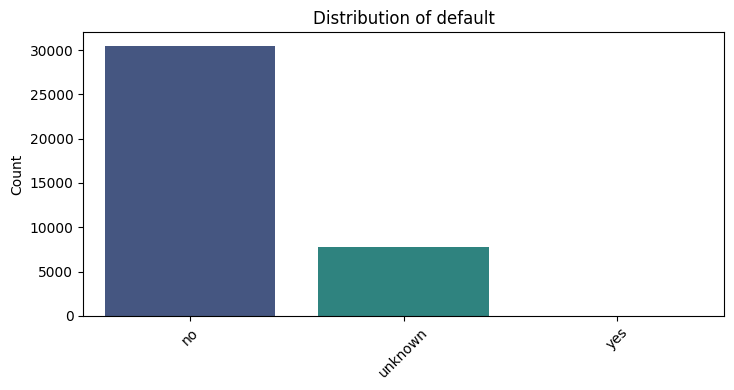

(30478, 21)

In [11]:
# Columns to check for "unknown" values
columns_with_unknowns = [col for col in categorical_features if 'unknown' in df_cleaned[col].values]

# Plotting the distribution of categorical features
plot_categorical_distribution(df_cleaned, columns_with_unknowns)

# Drop rows with "unknown" values in the specified columns
for column in columns_with_unknowns:
    df_cleaned = df_cleaned[df_cleaned[column] != 'unknown']

df_cleaned.shape

Dropping "unknown" values in the "default" feature when their count exceeded 5% ensures data quality for a critical financial indicator, as high uncertainty in this feature can significantly impact model accuracy and reliability. This approach prevents potential biases and inaccuracies, leading to better risk assessment and credit decision-making, which are crucial for the bank's operational integrity and regulatory compliance.

### **Review Missing Values**

In [12]:
# Verify that there are no more missing values
df_cleaned.isnull().sum()

age               0
job               0
marital           0
education         0
default           0
housing           0
loan              0
contact           0
month             0
day_of_week       0
duration          0
campaign          0
pdays             0
previous          0
poutcome          0
emp.var.rate      0
cons.price.idx    0
cons.conf.idx     0
euribor3m         0
nr.employed       0
y                 0
dtype: int64

We don't have any missing values in the dataset.  However, reviewing for missing values in a dataset is crucial to ensure data quality and accuracy. It helps prevent biases, improve model performance, and provide reliable business insights. Identifying missing values guides appropriate handling strategies, such as imputation or removal, ensuring robust data analysis and decision-making. Properly addressing missing values is essential for creating accurate, reliable, and effective machine learning models.

In [13]:
# Display few rows of the encoded dataset
df_cleaned.sample(10)

,age,job,marital,education,default,housing,loan,contact,month,day_of_week,duration,campaign,pdays,previous,poutcome,emp.var.rate,cons.price.idx,cons.conf.idx,euribor3m,nr.employed,y
27534,53,retired,married,high.school,no,no,no,cellular,nov,fri,268,3,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,no
31839,52,technician,married,professional.course,no,no,no,cellular,may,thu,94,1,999,0,nonexistent,-1.8,92.893,-46.2,1.327,5099.1,no
28198,36,blue-collar,married,basic.9y,no,yes,no,cellular,apr,tue,226,1,999,0,nonexistent,-1.8,93.075,-47.1,1.453,5099.1,no
19809,47,self-employed,married,basic.9y,no,yes,no,cellular,aug,fri,97,2,999,0,nonexistent,1.4,93.444,-36.1,4.966,5228.1,no
1657,25,admin.,married,high.school,no,no,no,telephone,may,fri,498,1,999,0,nonexistent,1.1,93.994,-36.4,4.855,5191.0,no
28044,46,management,married,university.degree,no,no,no,cellular,apr,thu,249,1,999,0,nonexistent,-1.8,93.075,-47.1,1.483,5099.1,no
7072,35,technician,single,university.degree,no,no,no,telephone,may,thu,52,5,999,0,nonexistent,1.1,93.994,-36.4,4.860,5191.0,no
27383,42,admin.,married,university.degree,no,yes,no,cellular,nov,fri,184,2,999,0,nonexistent,-0.1,93.200,-42.0,4.021,5195.8,no
24195,44,management,married,high.school,no,yes,no,cellular,nov,mon,231,2,999,0,nonexistent,-0.1,93.200,-42.0,4.191,5195.8,no
37109,38,management,married,university.degree,no,no,no,cellular,jul,tue,486,5,999,0,nonexistent,-2.9,92.469,-33.6,0.908,5076.2,yes


### **Understand the distribution of Numerical Features**

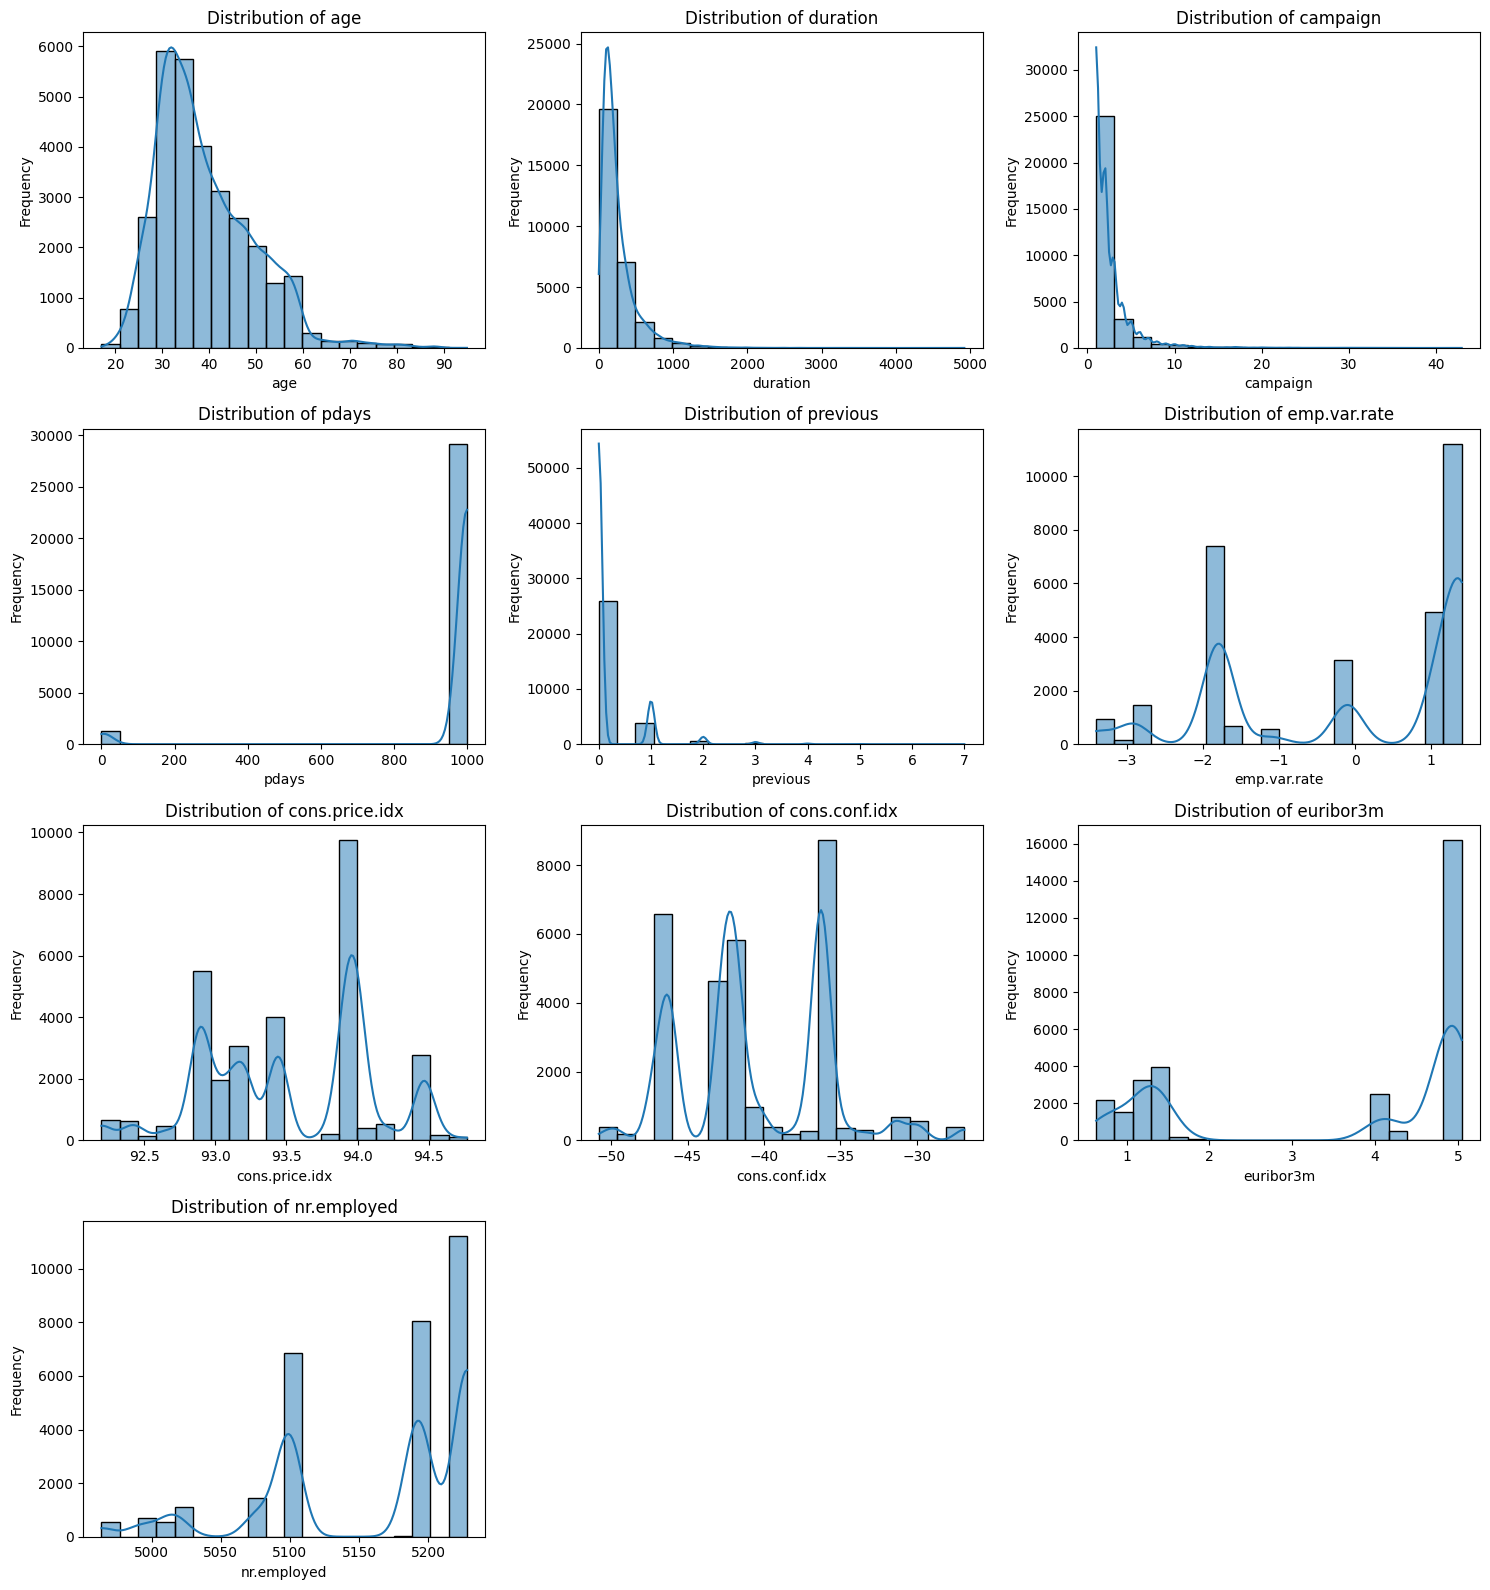

In [14]:
def plot_feature_distributions(df):
    """
    Plots the distributions of each feature in the DataFrame.

    Parameters:
        df (DataFrame): The DataFrame with features to plot.
    """
    num_features = len(df.columns)
    num_rows = (num_features + 2) // 3

    plt.figure(figsize=(15, 4 * num_rows))
    for i, col in enumerate(df.columns):
        plt.subplot(num_rows, 3, i + 1)
        sns.histplot(data=df, x=col, kde=True, bins=20)
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
        plt.ylabel("Frequency")

    plt.tight_layout()
    plt.show()

# Select only numeric columns
numerical_columns_df = df_cleaned.select_dtypes(exclude=['object'])

# Plot feature distributions
plot_feature_distributions(numerical_columns_df)

The above histograms illustrate the distribution of numerical features in the dataset:

**Age:** Most clients are between 30-40 years old, with a right-skewed distribution indicating fewer older clients.

**Duration:** The duration of calls is highly right-skewed, with most calls lasting less than 500 seconds.

**Campaign:** The number of contacts performed during the campaign is heavily right-skewed, with most clients being contacted fewer than 10 times.

**Pdays:** The number of days since the client was last contacted has a significant peak at 999, indicating many clients were not previously contacted.

**Previous:** Most clients had 0 or 1 previous contacts, with very few having more than 2.

**Emp.var.rate:** The employment variation rate shows distinct peaks around -3, 1, and 1.4, indicating economic cycles.

**Cons.price.idx:** Consumer price index has several peaks, indicating multiple inflation periods during the data collection.

**Cons.conf.idx:** Consumer confidence index shows peaks around -30, -35, -40, and -50, reflecting varying levels of consumer sentiment.

**Euribor3m:** The Euribor 3-month rate is right-skewed, with many values clustered around 4.5.

**Nr.employed:** The number of employees has multiple peaks, reflecting employment variations over time.

These distributions indicate a mix of skewed and multimodal distributions, suggesting the presence of economic cycles and variability in client contact behavior. This information is crucial for feature engineering and model development.

### **Examine the relationship between categorical features and the target variable (`y`).**

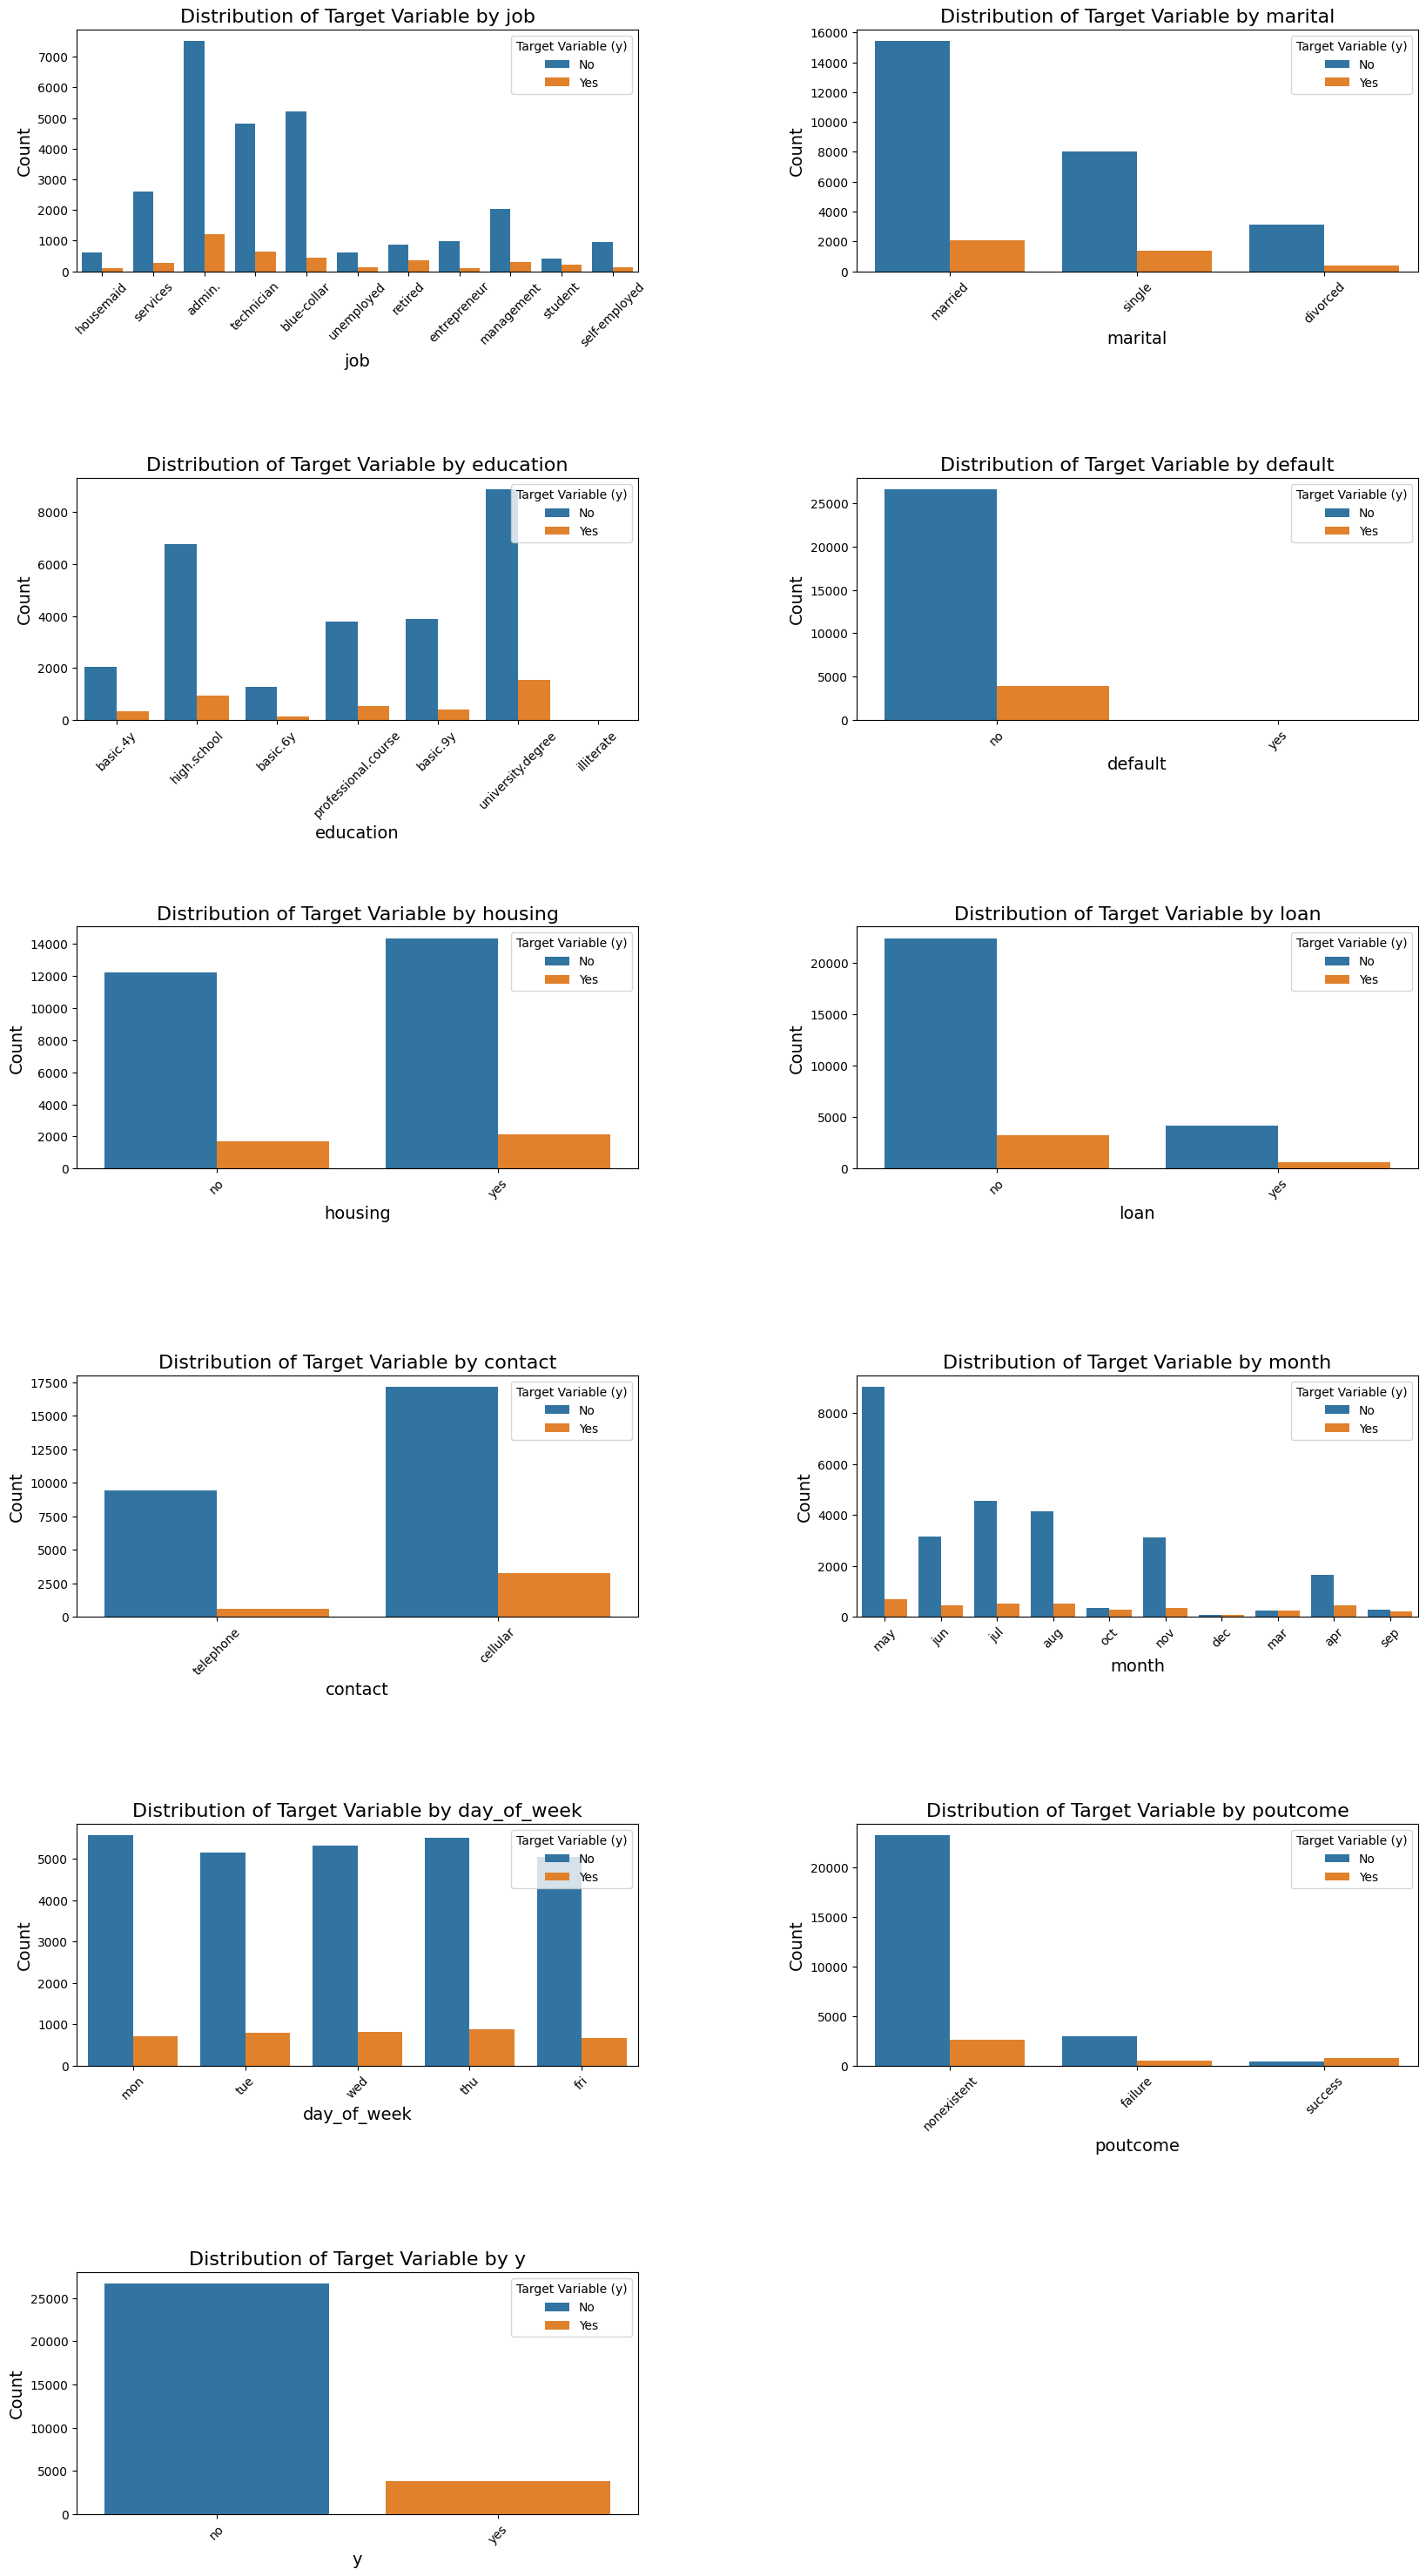

In [15]:
# Plot bar plots for categorical features
fig, axes = plt.subplots(nrows=len(categorical_features)//2 + len(categorical_features)%2, ncols=2, figsize=(20, len(categorical_features)*3))
fig.tight_layout(pad=15.0)

for i, feature in enumerate(categorical_features):
    row, col = i // 2, i % 2
    sns.countplot(data=df_cleaned, x=feature, hue='y', ax=axes[row, col])
    axes[row, col].set_title(f'Distribution of Target Variable by {feature}', fontsize=16)
    axes[row, col].set_xlabel(feature, fontsize=14)
    axes[row, col].set_ylabel('Count', fontsize=14)
    axes[row, col].legend(title='Target Variable (y)', loc='upper right', labels=['No', 'Yes'])
    axes[row, col].tick_params(axis='x', rotation=45)

# Remove any empty subplots
if len(categorical_features) % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.show()


The charts illustrate the distribution of the target variable y (whether a client subscribed to a term deposit) across various categorical features.

**Job:** The highest subscription rates are seen among students and retired individuals, while blue-collar and management jobs show lower rates.

**Marital Status:** Single clients have a higher subscription rate compared to married and divorced clients.

**Education:** University degree holders and individuals with higher education levels are more likely to subscribe, while those with basic education have lower subscription rates.

**Default:** Clients without credit in default are significantly more likely to subscribe compared to those with defaults.

**Housing Loan:** Clients without housing loans are more likely to subscribe than those with housing loans.

**Personal Loan:** Clients without personal loans show higher subscription rates.

**Contact Method:** Clients contacted via cellular phones have a higher subscription rate compared to those contacted via telephone.

**Month:** May shows the highest number of contacts but a lower subscription rate, while months like March and September show higher subscription rates.

**Day of the Week:** Subscription rates are relatively consistent across different days of the week.

**Previous Outcome:** Clients with a successful outcome in a previous campaign are more likely to subscribe again.

These insights suggest that job type, education level, absence of loans, and previous successful outcomes are strong indicators of a client's likelihood to subscribe to a term deposit.

### **Examine the relationship between numerical features and the target variable (`y`).**

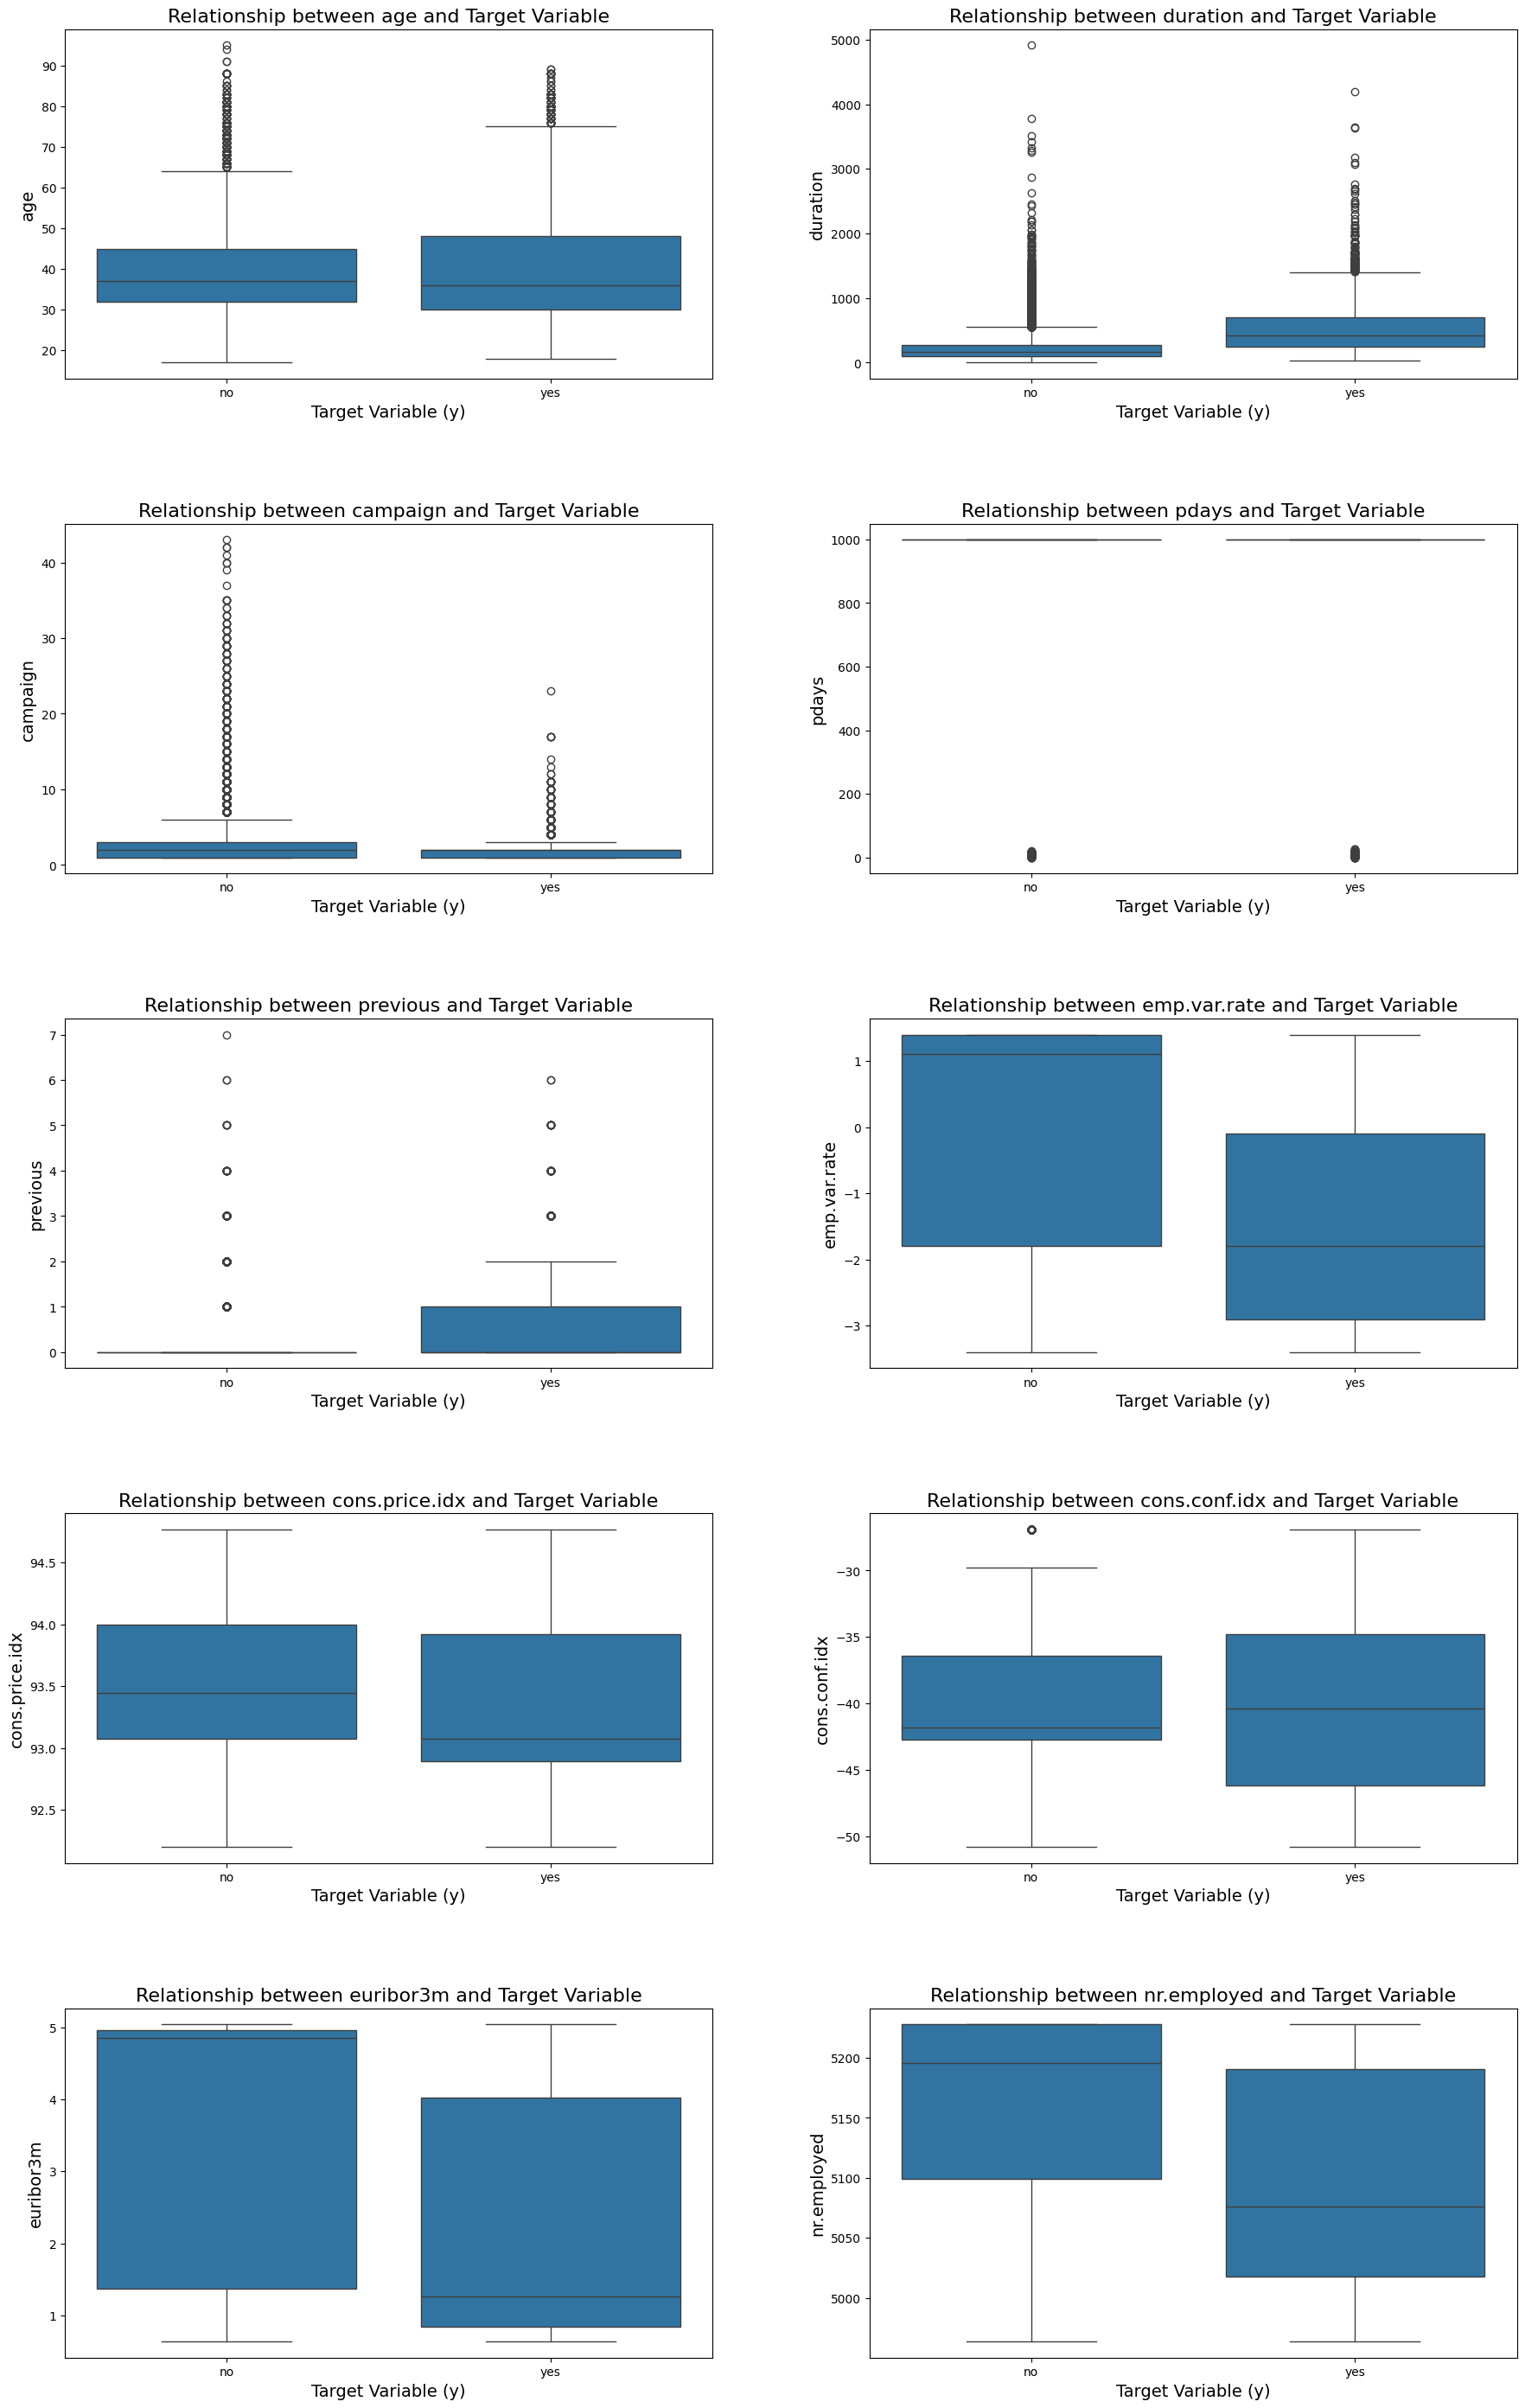

In [16]:
# Define numerical features
numerical_features = df_cleaned.select_dtypes(exclude=['object']).columns

# Plot box plots for numerical features
fig, axes = plt.subplots(nrows=len(numerical_features)//2 + len(numerical_features)%2, ncols=2, figsize=(20, len(numerical_features)*3))
fig.tight_layout(pad=10.0)

for i, feature in enumerate(numerical_features):
    row, col = i // 2, i % 2
    sns.boxplot(data=df_cleaned, x='y', y=feature, ax=axes[row, col])
    axes[row, col].set_title(f'Relationship between {feature} and Target Variable', fontsize=16)
    axes[row, col].set_xlabel('Target Variable (y)', fontsize=14)
    axes[row, col].set_ylabel(feature, fontsize=14)

# Remove any empty subplots
if len(numerical_features) % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.show()


The box plots illustrate the relationship between various numerical features and the target variable  y (whether a client subscribed to a term deposit).

**Age:** Both subscribed and non-subscribed clients have similar age distributions, with a median around 38 years. Age does not show significant differentiation.

**Duration:** Clients who subscribed generally have longer call durations. This feature shows a noticeable difference, indicating that longer interactions might increase subscription rates.

**Campaign:** Both groups have similar distributions, but outliers in the non-subscribed group suggest more contacts without success. Excessive contact attempts may not be effective.

**Pdays:** Both groups show a large number of 999 values, indicating no previous contact. However, a few non-subscribers show recent contacts, suggesting follow-ups might need better targeting.

**Previous:** Clients with previous contacts tend to subscribe more, as indicated by the higher median in the subscribed group. Previous successful contacts positively impact subscription.

**Emp.var.rate:** Higher employment variation rates are more associated with non-subscribers, while lower rates are linked to subscribers, indicating economic stability might influence decisions.

**Cons.price.idx:** Both groups show similar distributions, suggesting consumer price index does not significantly impact subscription likelihood.

**Cons.conf.idx:** Subscribers tend to have slightly better consumer confidence index values, indicating a mild influence of consumer sentiment.

**Euribor3m:** Lower Euribor rates are more associated with subscribers, indicating favorable interest rates might encourage subscriptions.

**Nr.employed:** A higher number of employees correlate slightly with subscriptions, indicating employment levels may have a minor influence.

These insights suggest that call duration, previous contacts, employment variation rate, and Euribor rates are significant indicators of subscription likelihood, guiding targeted marketing strategies.

### **Examine the relationship between selected features and the target variable (`y`) in a scatter plot.**

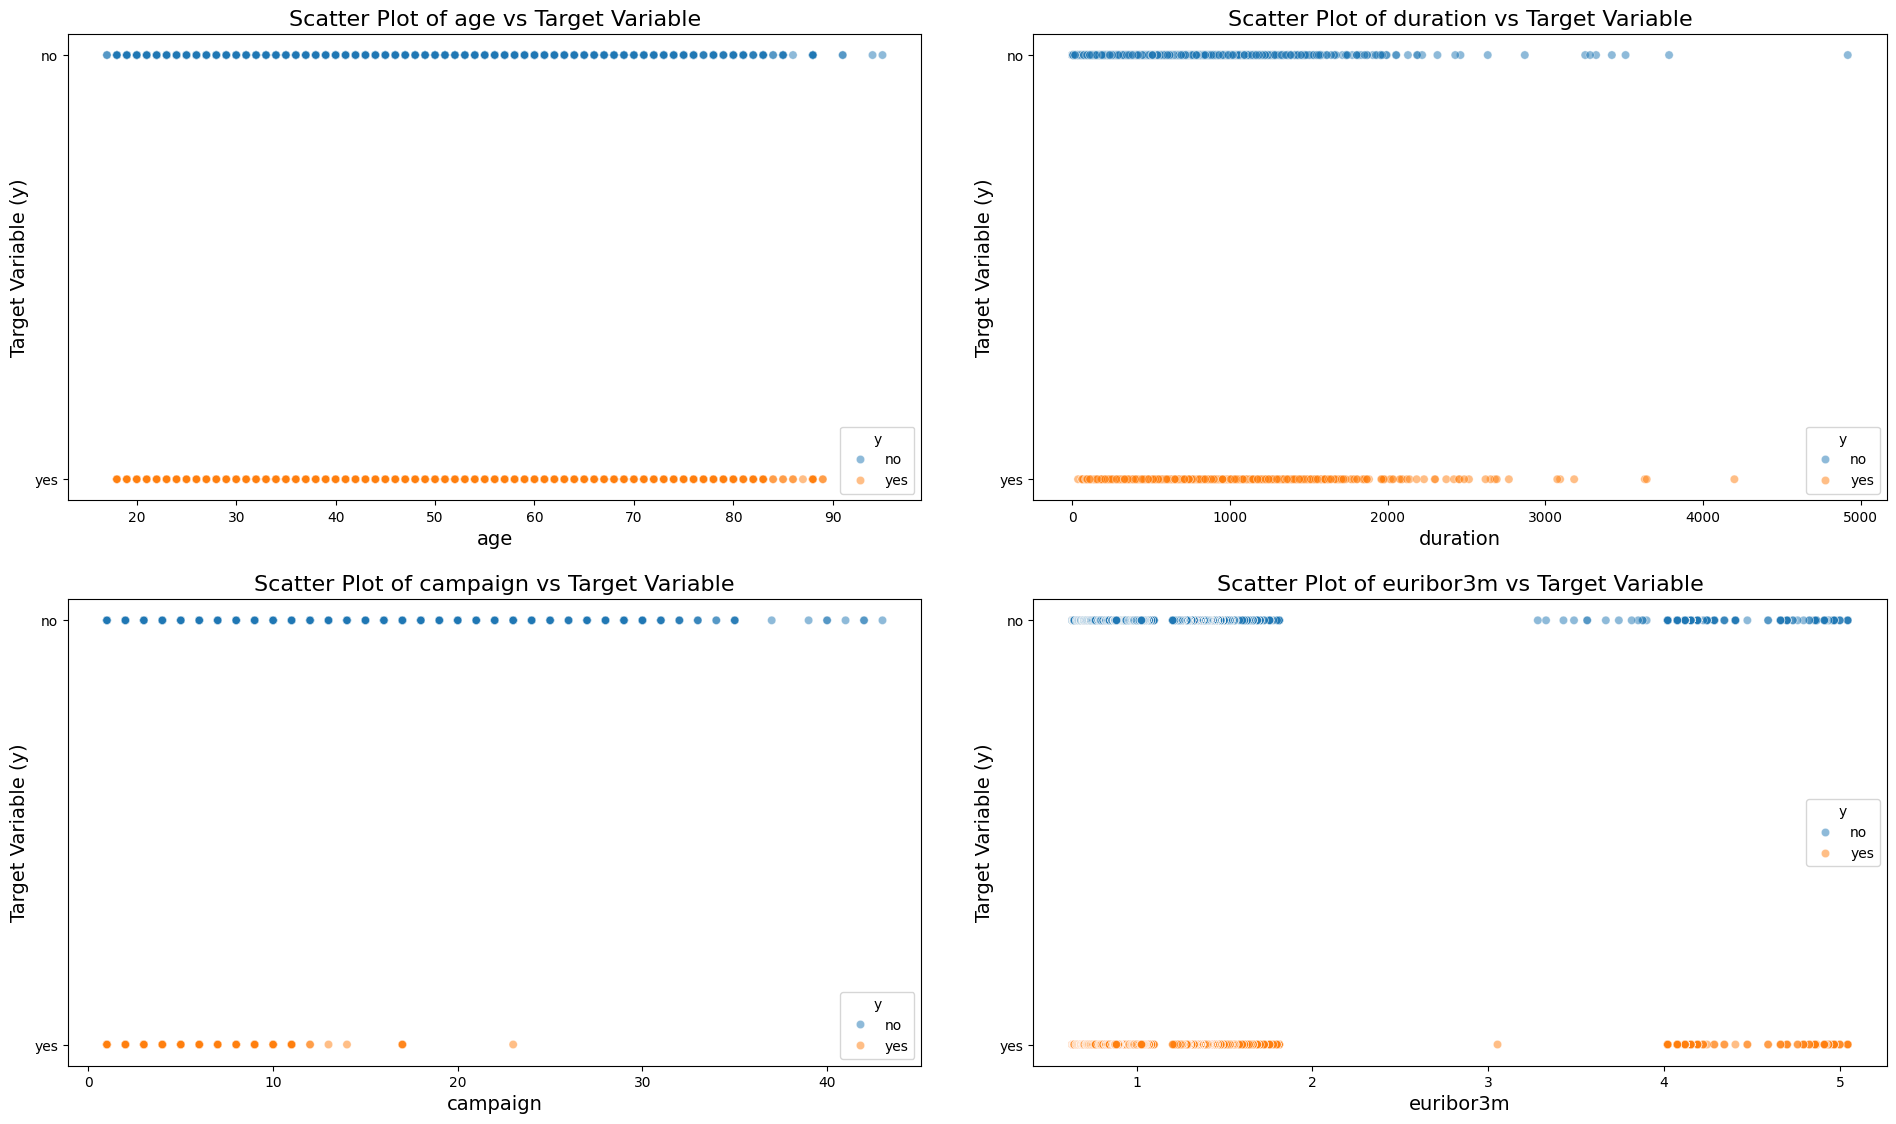

In [17]:
# Plot scatter plots for selected numerical features
selected_numerical_features = ['age', 'duration', 'campaign', 'euribor3m']

fig, axes = plt.subplots(nrows=len(selected_numerical_features)//2 + len(selected_numerical_features)%2, ncols=2, figsize=(20, len(selected_numerical_features)*3))
fig.tight_layout(pad=5.0)

for i, feature in enumerate(selected_numerical_features):
    row, col = i // 2, i % 2
    sns.scatterplot(data=df_cleaned, x=feature, y='y', hue='y', alpha=0.5, ax=axes[row, col])
    axes[row, col].set_title(f'Scatter Plot of {feature} vs Target Variable', fontsize=16)
    axes[row, col].set_xlabel(feature, fontsize=14)
    axes[row, col].set_ylabel('Target Variable (y)', fontsize=14)

# Remove any empty subplots
if len(selected_numerical_features) % 2 != 0:
    fig.delaxes(axes[-1, -1])

plt.show()

The scatter plots illustrate the relationship between selected numerical features and the target variable y (whether a client subscribed to a term deposit).

**Age:** The scatter plot shows that the age distribution is similar for both subscribed and non-subscribed clients, with no clear pattern differentiating the two groups.

**Duration:** There is a clear distinction in call duration between subscribers and non-subscribers. Subscribers tend to have longer call durations, indicating that the length of the call positively influences the likelihood of subscription.

**Campaign:** The scatter plot indicates that most clients who did not subscribe were contacted fewer times, while a few non-subscribers had a high number of contacts. Conversely, subscribers generally had fewer contact attempts, suggesting that too many contacts might not be effective.

**Euribor3m:** The plot shows that clients who subscribed tend to have lower Euribor rates. Higher Euribor rates are associated more with non-subscribers, indicating that favorable interest rates may influence the decision to subscribe.

**Insights**

**Duration:** Longer call durations are significantly associated with higher subscription rates, emphasizing the importance of engaging conversations during marketing calls.

**Campaign:** Over-contacting clients can lead to diminishing returns, highlighting the need for optimal contact strategies.

**Euribor3m:** Lower interest rates are more likely to lead to subscriptions, suggesting economic conditions play a role in client decisions.

These insights can guide marketing strategies, focusing on quality interactions over quantity and leveraging economic conditions to target potential subscribers effectively.

In [18]:
# Shape of the dataset after cleaning
df_cleaned.shape

(30478, 21)

## **Problem 4: Understanding the Task**

After examining the description and data, your goal now is to clearly state the *Business Objective* of the task.  State the objective below.

*The primary business objective is to enhance the efficiency of the bank's direct marketing campaigns for long-term deposit subscriptions. By leveraging data mining techniques within the CRISP-DM framework, the goal is to develop a predictive model that accurately identifies potential customers who are likely to subscribe to a deposit. This model aims to improve resource allocation, reduce unnecessary contact attempts, and increase the overall success rate of the campaigns. By identifying key factors that influence customer decisions, the bank can target high-quality prospects more effectively, thus optimizing human effort, reducing costs, and maximizing the return on investment for marketing efforts.*

## **Problem 5: Engineering Features**

Now that you understand your business objective, we will build a basic model to get started.  Before we can do this, we must work to encode the data.  Using just the bank information features, prepare the features and target column for modeling with appropriate encoding and transformations.

### **Visualize correlated features in a Heatmap**

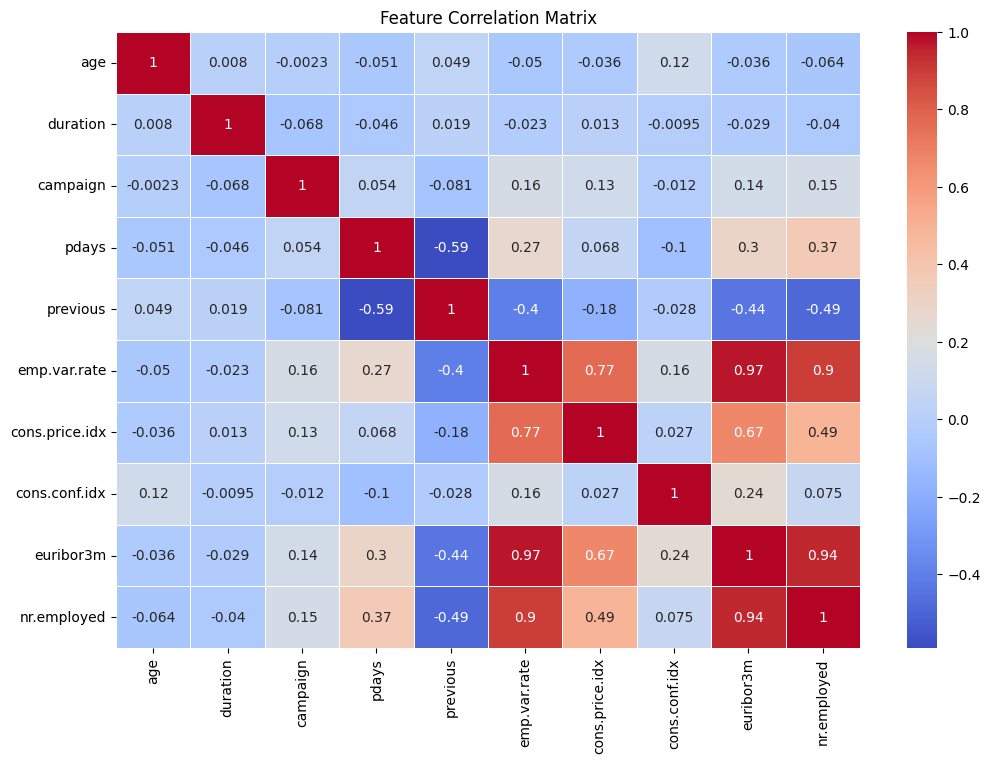

In [19]:
def plot_correlation_matrix(df, title='Feature Correlation Matrix', figsize=(12, 8), cmap='coolwarm'):
    """
    This function takes a DataFrame, computes the correlation matrix of its numerical features,
    and plots a heatmap of the correlation matrix.

    Parameters:
    - df (pd.DataFrame): The DataFrame to analyze.
    - figsize (tuple): The size of the figure (width, height) in inches.
    - cmap (str): The colormap for the heatmap.

    Returns:
    - None
    """
    # Define numerical features
    numerical_features = df.select_dtypes(exclude=['object']).columns
    
    # Calculate the correlation matrix
    correlation_matrix = df[numerical_features].corr()
    
    # Plot the heatmap
    plt.figure(figsize=figsize)
    sns.heatmap(correlation_matrix, annot=True, cmap=cmap, linewidths=0.5)
    plt.title(title)
    plt.show()

plot_correlation_matrix(df_cleaned)

The correlation matrix heatmap illustrates the linear relationships between numerical features in the dataset.

**Key Insights**

**Emp.var.rate, Euribor3m, and Nr.employed:**
These features are highly correlated with each other (correlation coefficients > 0.9). This suggests multicollinearity, indicating that they may be capturing similar economic trends or conditions. It may be beneficial to remove or combine these features to avoid redundancy in modeling.

**Pdays and Previous:**
These features have a strong negative correlation (-0.59), indicating that as the number of days since the client was last contacted increases, the number of previous contacts decreases. This inverse relationship is expected, as more recent contacts imply fewer previous attempts.

**Emp.var.rate and Cons.price.idx:**
There is a moderate positive correlation (0.77) between the employment variation rate and the consumer price index, suggesting that periods of economic change (employment variation) are associated with changes in the consumer price index.

**Pdays and Nr.employed:**
A moderate positive correlation (0.37) suggests that higher numbers of days since the last contact are associated with higher employment numbers, possibly indicating a broader economic context where employment trends impact contact strategy.

**Weak Correlations:**
Most other features show weak correlations (close to 0), indicating that they are relatively independent of each other. This independence can be useful for machine learning models, as it provides a diverse set of features without much redundancy.

**Actions**

**Feature Selection:** Consider removing or combining highly correlated features (e.g., `emp.var.rate, euribor3m, nr.employed`) to reduce multicollinearity.

**Modeling Strategies:** Use dimensionality reduction techniques like PCA if you decide to keep correlated features.

**Economic Indicators:** Leverage insights from `emp.var.rate` and `cons.price.idx` correlations to understand the economic conditions affecting customer behavior.

These steps help ensure robust and interpretable models by addressing multicollinearity and utilizing diverse, informative features.

### **Drop highly correlated features > 0.8**

In [20]:
# Calculate the correlation matrix
correlation_matrix = df_cleaned[numerical_features].corr().abs()

# Select upper triangle of correlation matrix
upper_triangle = correlation_matrix.where(np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Find features with correlation greater than 0.8
highly_correlated_features = [column for column in upper_triangle.columns if any(upper_triangle[column] > 0.8)]

# Drop highly correlated features
df_cleaned = df_cleaned.drop(columns=highly_correlated_features)

print("Features dropped due to high correlation:", highly_correlated_features)
print("Remaining features:", df_cleaned.columns)

Features dropped due to high correlation: ['euribor3m', 'nr.employed']
Remaining features: Index(['age', 'job', 'marital', 'education', 'default', 'housing', 'loan',
       'contact', 'month', 'day_of_week', 'duration', 'campaign', 'pdays',
       'previous', 'poutcome', 'emp.var.rate', 'cons.price.idx',
       'cons.conf.idx', 'y'],
      dtype='object')


**Reasons for Eliminating Correlated Features > 0.8**

Eliminating features with a correlation greater than 0.8 is crucial to address multicollinearity, which occurs when two or more features are highly correlated. Multicollinearity can negatively impact machine learning models by:

**Reducing Model Interpretability:** High correlation among features makes it difficult to determine the individual effect of each feature on the target variable, leading to less interpretable models.

**Increasing Variance:** Multicollinearity can inflate the variance of the coefficient estimates, making the model sensitive to changes in the training data. This can result in less reliable predictions.

**Impacting Feature Importance:** In tree-based models, highly correlated features can distort the importance measures, leading to biased feature selection.

By removing highly correlated features, we ensure that the remaining features are more independent, enhancing the model's interpretability and stability. This leads to more robust and reliable predictions, essential for making informed decisions based on the model's output.

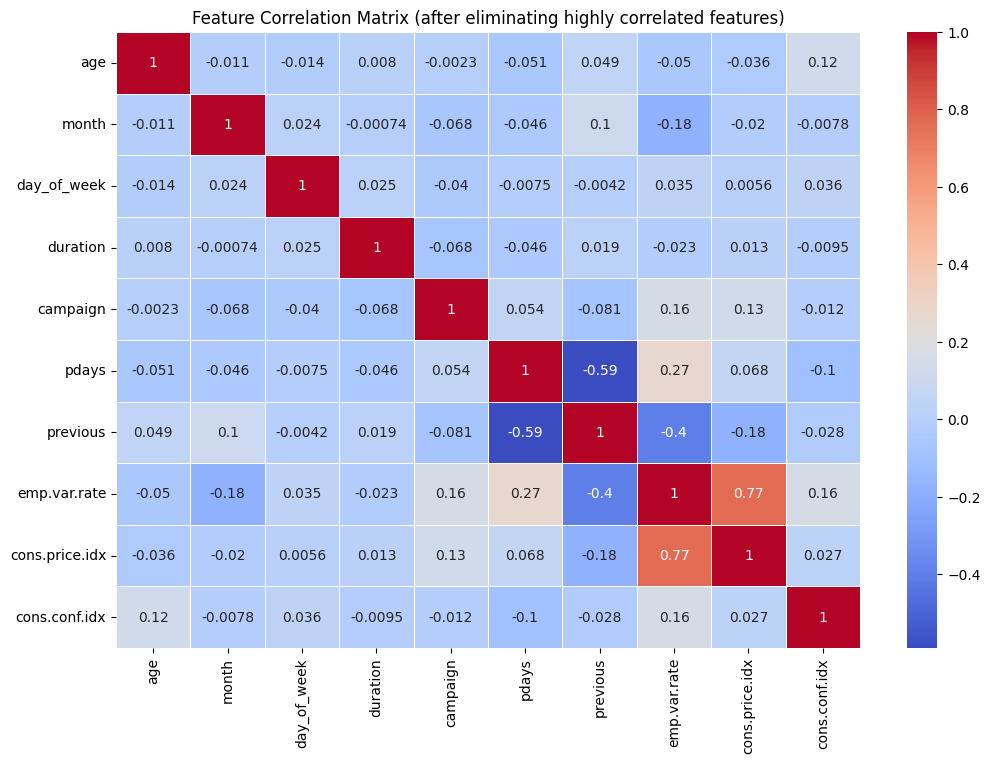

In [38]:
# Plot correlation matrix after addressing multicollinearity
plot_correlation_matrix(df_cleaned, title='Feature Correlation Matrix (after eliminating highly correlated features)')

### **Apply Transformations - Log Transformer, StandardScaler, OneHotEncoder and LabelEncoder**

In [22]:
# Define categorical and numerical features
numerical_features = ['age', 'duration', 'campaign', 'pdays', 'previous', 'emp.var.rate', 'cons.price.idx', 'cons.conf.idx']
categorical_features = ['job', 'marital', 'education', 'default', 'housing', 'loan', 'contact', 'poutcome']
label_encoded_features = ['month', 'day_of_week']

target = df_cleaned['y'].map({'yes': 1, 'no': 0})

# Apply Label Encoding to 'month' and 'day_of_week'
label_encoder = LabelEncoder()
for feature in label_encoded_features:
    df_cleaned[feature] = label_encoder.fit_transform(df_cleaned[feature])

# Handle zero or negative values by adding a small constant before applying log transformation
def safe_log_transform(x):
    x = np.where(x <= 0, 1e-6, x)
    return np.log1p(x)

# Define the ColumnTransformer with log transformation followed by standard scaling for numerical features
log_transformer = FunctionTransformer(safe_log_transform, validate=True)
preprocessor = ColumnTransformer(
    transformers=[
        ('num', Pipeline([('log', log_transformer), ('scaler', StandardScaler())]), numerical_features),
        ('cat', OneHotEncoder(drop='first'), categorical_features),
        ('lbl', 'passthrough', label_encoded_features)
    ])

# Apply the preprocessor to the entire dataset
data_preprocessed = preprocessor.fit_transform(df_cleaned)

# Get feature names for OneHotEncoder and combine with numerical and label encoded features
onehot_features = preprocessor.named_transformers_['cat'].get_feature_names_out(categorical_features).tolist()
all_features = numerical_features + onehot_features + label_encoded_features

# Convert the preprocessed data back to a DataFrame
df_encoded = pd.DataFrame(data_preprocessed, columns=all_features)

# Add the target variable back to the preprocessed DataFrame
df_encoded['y'] = target.values

# Display few rows of the encoded dataset
df_encoded.sample(10)

,age,duration,campaign,pdays,previous,emp.var.rate,cons.price.idx,cons.conf.idx,job_blue-collar,job_entrepreneur,job_housemaid,job_management,job_retired,job_self-employed,job_services,job_student,job_technician,job_unemployed,marital_married,marital_single,education_basic.6y,education_basic.9y,education_high.school,education_illiterate,education_professional.course,education_university.degree,default_yes,housing_yes,loan_yes,contact_telephone,poutcome_nonexistent,poutcome_success,month,day_of_week,y
27336,-1.953347,-0.452653,-0.859204,0.210801,-0.406465,-1.055806,-2.271038,2.117582e-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0
261,0.691043,-0.249435,-0.859204,0.210801,-0.406465,0.715024,0.804776,2.117582e-22,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,1.0,0.0,6.0,3.0,0
17192,-0.193920,-1.043691,-0.022765,0.210801,1.921760,-1.055806,-0.550071,2.117582e-22,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,7.0,3.0,0
17662,-1.046354,-0.304894,-0.859204,0.210801,-0.406465,-1.055806,-0.550071,2.117582e-22,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7.0,4.0,0
13569,-0.085524,0.759292,-0.022765,0.210801,-0.406465,1.033733,-0.132509,2.117582e-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,3.0,0
21250,0.778458,0.347857,-0.859204,0.210801,-0.406465,-1.055806,-0.764406,2.117582e-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0
16997,-0.658954,-0.434193,-0.859204,0.210801,-0.406465,-1.055806,-0.550071,2.117582e-22,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,7.0,3.0,0
21318,0.601707,1.140084,-0.022765,0.210801,-0.406465,-1.055806,-0.764406,2.117582e-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,1.0,0.0,0.0,2.0,1
17864,0.947841,1.949695,1.031024,0.210801,-0.406465,-1.055806,-0.550071,2.117582e-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,7.0,4.0,1
29685,-1.953347,0.683274,-0.859204,0.210801,-0.406465,-1.055806,1.179867,2.117582e-22,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,2.0,0


**Reasons for applying these Data Transformations**

**Label Encoding for `month` and `day_of_week`:** Converts categorical labels into numeric form, making them usable for algorithms that require numeric input.

**Log Transformer:** Stabilizes variance and reduces skewness, making highly skewed data more normally distributed, which can improve model performance.

**StandardScaler:** Normalizes features to have zero mean and unit variance, ensuring that each feature contributes equally and is important for distance-based algorithms. It ensures that each feature contributes equally to the model, particularly important for algorithms sensitive to feature scales (e.g., SVM, logistic regression).

**OneHotEncoder:** Converts categorical features into binary vectors, preventing the algorithm from interpreting categorical values as ordinal, preserving the categorical nature.

These transformations ensure the data is in an optimal format for machine learning models, enhancing performance and interpretability.

In [23]:
# Shape of the dataset after encoding
df_encoded.shape

(30478, 35)

## **Problem 6: Train/Test Split**

With your data prepared, split it into a train and test set.

In [24]:
# Split the data into features and labels
data = df_encoded.drop(columns=['y'])
labels = df_encoded['y']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(data, labels, test_size=0.3, random_state=42, stratify=labels)

The `train_test_split` function is used to divide the data into training and testing sets, with 70% of the data used for training (X_train, y_train) and 30% for testing (X_test, y_test). The `stratify=labels` argument ensures that the class distribution in the training and testing sets mirrors the original distribution, maintaining balance for both classes.

### **Fix Class Imbalance on the training data using SMOTE**

In [25]:
# Apply SMOTE to training data
smote = SMOTE(random_state=42)
X_train, y_train = smote.fit_resample(X_train, y_train)

The Synthetic Minority Over-sampling Technique (SMOTE) is applied to the training data to address class imbalance. SMOTE generates synthetic samples for the minority class to balance the class distribution. By using `fit_resample` on "X_train" and "y_train", SMOTE creates a more balanced dataset, which can improve the performance and fairness of machine learning models. This step is crucial when dealing with imbalanced datasets to avoid biased model predictions.

In [26]:
# Create a dictionary to store the shapes
data_shapes = {
    'Dataset': ['X_train', 'X_test', 'y_train', 'y_test'],
    'Shape': [X_train.shape, X_test.shape, y_train.shape, y_test.shape]
}

# Create a DataFrame to display shapes in a neat format
shape_df = pd.DataFrame(data_shapes)

# Shape of the dataset after applying SMOTE
shape_df

,Dataset,Shape
0,X_train,"(37266, 34)"
1,X_test,"(9144, 34)"
2,y_train,"(37266,)"
3,y_test,"(9144,)"


After applying SMOTE - X_train has 37,266 samples and 34 features, while X_test has 9,144 samples and 34 features. The labels y_train and y_test have 37,266 and 9,144 samples, respectively, showing a balanced and appropriately sized training and testing split.

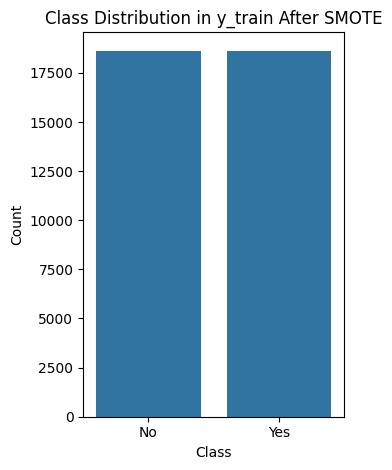

In [27]:
# Plot for y_train after SMOTE
plt.subplot(1, 2, 2)
sns.countplot(x=y_train)
plt.title('Class Distribution in y_train After SMOTE')
plt.xlabel('Class')
plt.ylabel('Count')
plt.xticks(ticks=[0, 1], labels=['No', 'Yes'])

plt.tight_layout()
plt.show()

The visualizations confirm that SMOTE has effectively balanced the class distribution in the training data, which can help improve model performance and fairness by ensuring that the model is not biased towards the majority class.

## **Problem 7: A Baseline Model**

Before we build our first model, we want to establish a baseline.  What is the baseline performance that our classifier should aim to beat?

In [28]:
# Identify the majority class
majority_class = y_train.value_counts().idxmax()
majority_class_count = y_train.value_counts().max()
total_count = len(y_train)

# Calculate the baseline accuracy
baseline_accuracy = majority_class_count / total_count

print(f"The majority class is: {majority_class}")
print(f"The baseline accuracy (majority class) is: {baseline_accuracy:.2f}")

The majority class is: 0
The baseline accuracy (majority class) is: 0.50


Establishing the baseline performance, which is the accuracy of always predicting the majority class, provides a benchmark to evaluate the effectiveness of machine learning models. It ensures that any model developed must outperform this simple strategy to be considered useful. If a model's performance is worse or only marginally better than the baseline, it indicates that the model might not be effectively capturing the underlying patterns in the data. This baseline helps in understanding the minimal expected performance and drives efforts to improve model accuracy and robustness.

## **Problem 8: A Simple Model**

Use Logistic Regression to build a basic model on your data.  

In [29]:
# Create and train the Logistic Regression model
log_reg = LogisticRegression(random_state=42)

start_time = time.time()
log_reg.fit(X_train, y_train)
train_time = time.time() - start_time

# Make predictions
train_pred = log_reg.predict(X_train)
test_pred = log_reg.predict(X_test)

## **Problem 9: Score the Model**

What is the accuracy of your model?

In [30]:
# Calculate accuracy
train_acc = accuracy_score(y_train, train_pred)
test_acc = accuracy_score(y_test, test_pred)

# Create a DataFrame to display the results
results_df = pd.DataFrame({
    'Model': ['Baseline', 'Logistic Regression'],
    'Train Time (s)': ['NA', train_time],
    'Train Accuracy': ['NA', train_acc],
    'Test Accuracy': [baseline_accuracy, test_acc]
})

results_df

,Model,Train Time (s),Train Accuracy,Test Accuracy
0,Baseline,NA,NA,0.500000
1,Logistic Regression,0.12816,0.85252,0.819226


By comparing the logistic regression model's test accuracy with the baseline accuracy, you can assess how much better (or worse) the model performs compared to the naive approach of always predicting the majority class. A significantly higher test accuracy indicates that the model effectively captures patterns in the data beyond the baseline.

### **Model Evaluation - Classification Report**

In [31]:
# Generate classification report
class_report = classification_report(y_test, test_pred, output_dict=True)

# Convert classification report to DataFrame for neat display
class_report_df = pd.DataFrame(class_report).transpose()
class_report_df

,precision,recall,f1-score,support
0,0.969046,0.819206,0.887849,7987.000000
1,0.396321,0.819360,0.534235,1157.000000
accuracy,0.819226,0.819226,0.819226,0.819226
macro avg,0.682684,0.819283,0.711042,9144.000000
weighted avg,0.896579,0.819226,0.843105,9144.000000


The classification report shows the performance of the logistic regression model on the test data:

**Class 0 (majority class):**

*Precision:* 0.97 - Very high precision, indicating most predicted negatives are true negatives.

*Recall:* 0.82 - Good recall, indicating most actual negatives are correctly identified.

*F1-Score:* 0.89 - Balanced performance.


**Class 1 (minority class):**

*Precision:* 0.40 - Lower precision, indicating many false positives.

*Recall:* 0.82 - Good recall, indicating most actual positives are correctly identified.

*F1-Score:* 0.53 - Moderate performance.

**Overall Metrics:**

*Accuracy:* 0.82 - The model correctly predicts 82% of instances.

*Macro Avg:* Reflects performance for each class equally.

*Weighted Avg:* Reflects performance accounting for class imbalance.


The model performs well for the majority class but struggles with the minority class, indicated by lower precision and F1-score for class 1.

### **ROC Curve, Precision-Recall Curve and Confusion Matrix - Logistic Regression model**

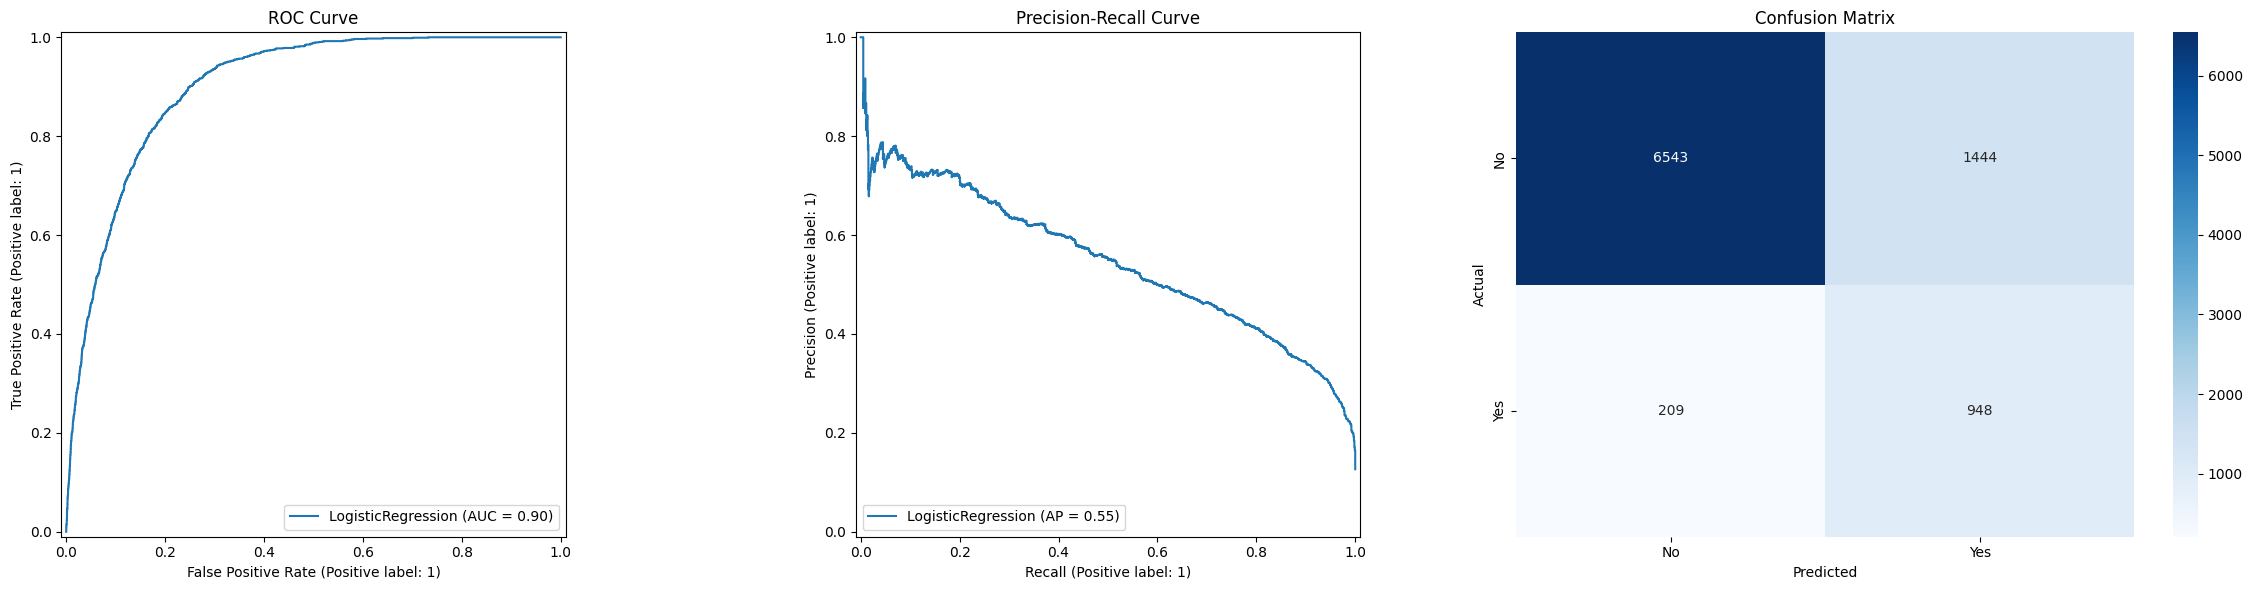

In [32]:
# ROC Curve, Precision-Recall Curve, and Confusion Matrix
fig, ax = plt.subplots(1, 3, figsize=(24, 6))

# ROC Curve
roc_display = RocCurveDisplay.from_estimator(log_reg, X_test, y_test, ax=ax[0])
roc_display.ax_.set_title('ROC Curve')

# Precision-Recall Curve
pr_display = PrecisionRecallDisplay.from_estimator(log_reg, X_test, y_test, ax=ax[1])
pr_display.ax_.set_title('Precision-Recall Curve')

# Confusion Matrix Heatmap
conf_matrix = confusion_matrix(y_test, test_pred)
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', ax=ax[2], xticklabels=['No', 'Yes'], yticklabels=['No', 'Yes'])
ax[2].set_title('Confusion Matrix')
ax[2].set_xlabel('Predicted')
ax[2].set_ylabel('Actual')

plt.tight_layout()
plt.show()

The charts provide comprehensive insights into the logistic regression model's performance on the test data:

**ROC Curve:**

<u>AUC = 0.90:</u> The Area Under the Curve (AUC) is 0.90, indicating excellent model performance. The model has a high true positive rate and a low false positive rate, reflecting good discrimination between the positive and negative classes.

**Precision-Recall Curve:**

<u>AP = 0.55:</u> The Average Precision (AP) score is 0.55, suggesting moderate performance. The precision-recall curve shows that the model maintains a relatively high precision for higher recall values, but precision drops as recall increases, indicating a trade-off.

**Confusion Matrix:**

<u>True Positives (TP):</u> 948 instances correctly predicted as 'Yes'.

<u>True Negatives (TN):</u> 6543 instances correctly predicted as 'No'.

<u>False Positives (FP):</u> 1444 instances incorrectly predicted as 'Yes'.

<u>False Negatives (FN):</u> 209 instances incorrectly predicted as 'No'.


The confusion matrix highlights that the model performs well on the majority class ('No') but has challenges with the minority class ('Yes'), as seen by the higher number of false positives and false negatives.

**Key Insights:**

<u>High AUC:</u> Indicates strong overall performance.

<u>Moderate AP:</u> Reflects the model's ability to balance precision and recall.

<u>Class Imbalance:</u> Despite good overall performance, the confusion matrix shows the need for further improvement in predicting the minority class accurately, suggesting potential areas for model enhancement.

## **Problem 10: Model Comparisons**

Now, we aim to compare the performance of the Logistic Regression model to our KNN algorithm, Decision Tree, and SVM models.  Using the default settings for each of the models, fit and score each.  Also, be sure to compare the fit time of each of the models.  Present your findings in a `DataFrame` similar to that below:

| Model | Train Time | Train Accuracy | Test Accuracy |
| ----- | ---------- | -------------  | -----------   |
|     |    |.     |.     |

In [33]:
# Define models
models = {
    'k-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(random_state=42),
    'SVM': SVC(kernel='linear', random_state=42)
}

# Fit and evaluate each model
results = []
for model_name, model in models.items():
    start_time = time.time()
    model.fit(X_train, y_train)
    train_time = time.time() - start_time
    train_pred = model.predict(X_train)
    test_pred = model.predict(X_test)
    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)
    results.append({
        'Model': model_name,
        'Train Time (s)': train_time,
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc
    })

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)
results_df

,Model,Train Time (s),Train Accuracy,Test Accuracy
0,k-Nearest Neighbors,0.004777,0.936994,0.826881
1,Decision Tree,0.199914,1.000000,0.867126
2,SVM,15.584901,0.853996,0.806321


The comparison table shows the performance of three models: k-Nearest Neighbors (kNN), Decision Tree, and Support Vector Machine (SVM).

**kNN:** Has a fast training time (0.003s), high train accuracy (0.94), and reasonable test accuracy (0.83), indicating potential overfitting.

**Decision Tree:** Takes longer to train (0.213s), achieves perfect train accuracy (1.00), and the highest test accuracy (0.87), but likely overfits due to perfect train accuracy.

**SVM:** Has the longest training time (14.97s), moderate train accuracy (0.85), and the lowest test accuracy (0.81), suggesting it may generalize better but needs tuning.

**Key Insights:**

**Training Time:** kNN is the fastest, SVM is the slowest.

**Train Accuracy:** Decision Tree overfits with perfect accuracy.

**Test Accuracy:** Decision Tree performs the best, indicating better generalization, though it might still be overfitting.

### **ROC Curve, Precision-Recall Curve and Confusion Matrix - KNN, Decision Tree, and SVM models**

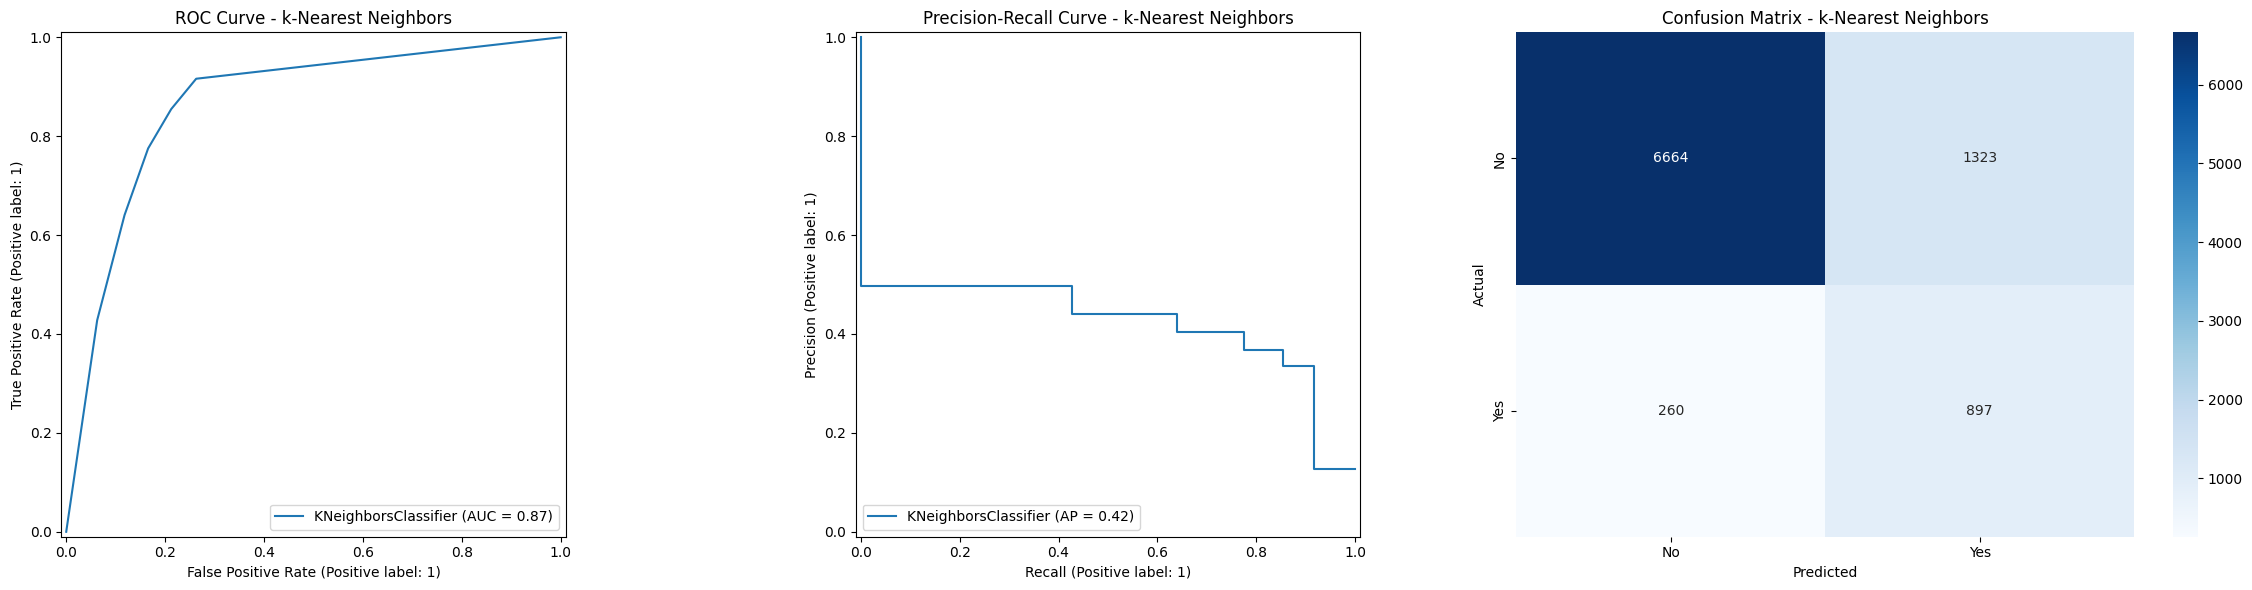

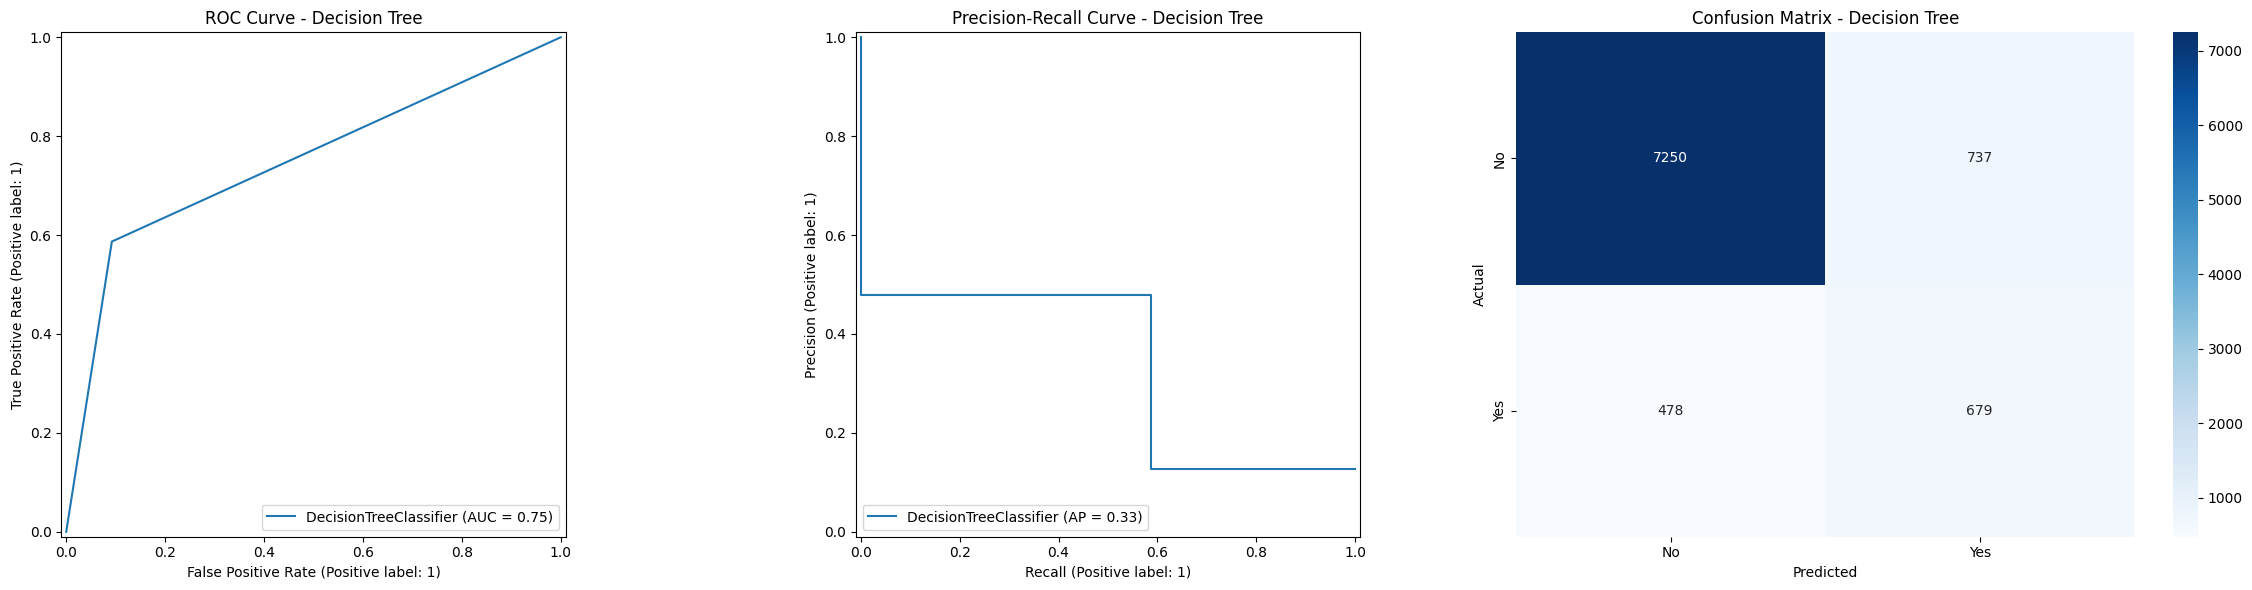

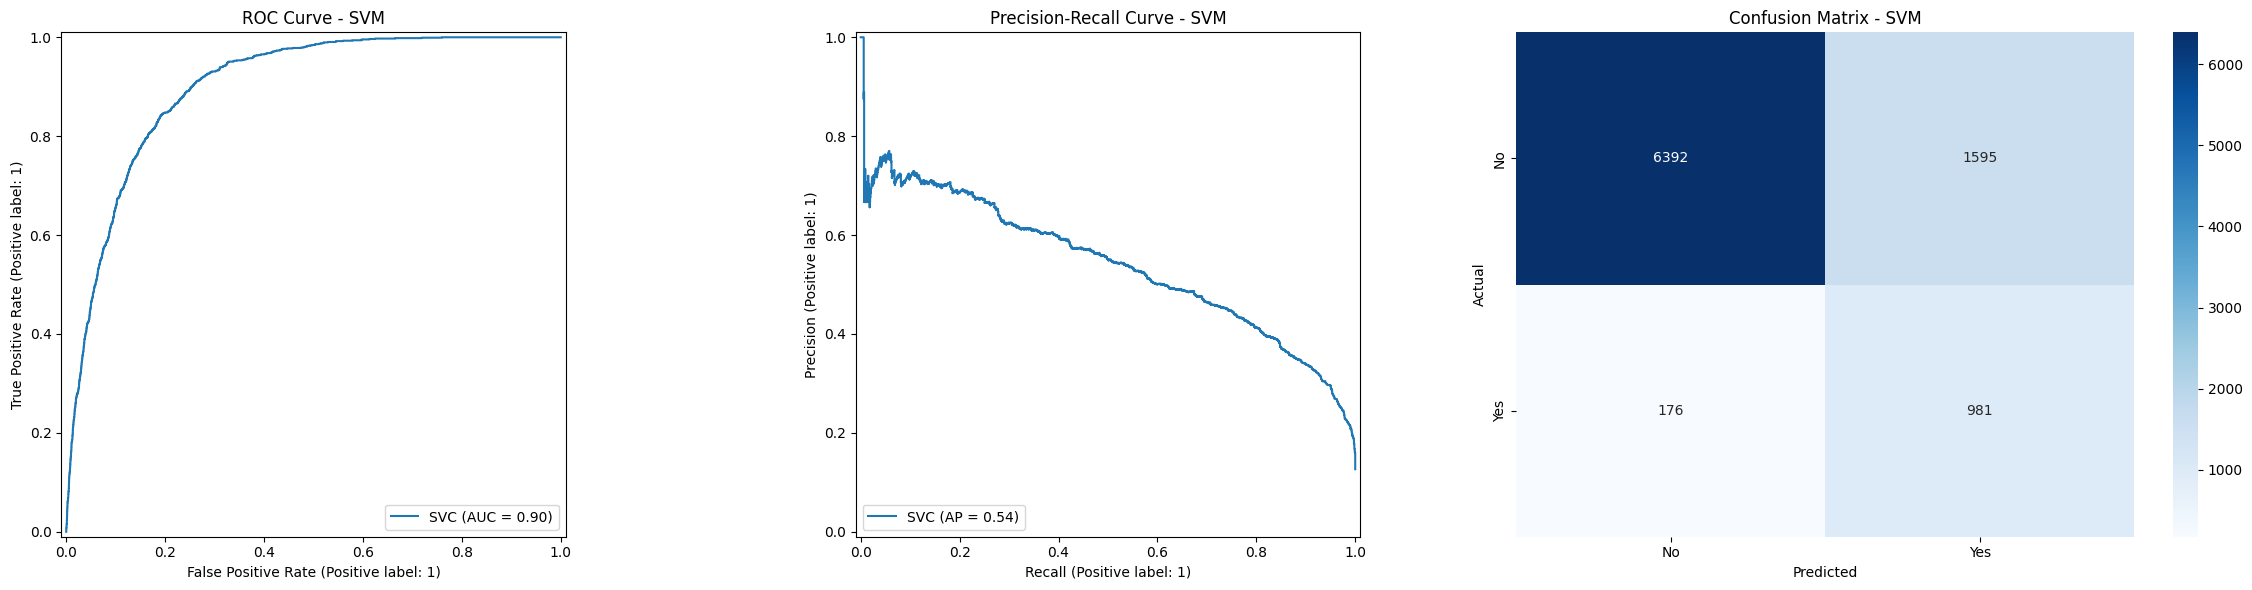

In [34]:
visualizations = []
for model_name, model in models.items():
    # Generate visualizations
    fig, ax = plt.subplots(1, 3, figsize=(24, 6))
    
    # ROC Curve
    roc_display = RocCurveDisplay.from_estimator(model, X_test, y_test, ax=ax[0])
    roc_display.ax_.set_title(f'ROC Curve - {model_name}')
    
    # Precision-Recall Curve
    pr_display = PrecisionRecallDisplay.from_estimator(model, X_test, y_test, ax=ax[1])
    pr_display.ax_.set_title(f'Precision-Recall Curve - {model_name}')
    
    # Confusion Matrix Heatmap
    test_pred = model.predict(X_test)
    conf_matrix = confusion_matrix(y_test, test_pred)
    conf_matrix_df = pd.DataFrame(conf_matrix, index=['No', 'Yes'], columns=['No', 'Yes'])
    sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', ax=ax[2])
    ax[2].set_title(f'Confusion Matrix - {model_name}')
    ax[2].set_xlabel('Predicted')
    ax[2].set_ylabel('Actual')
    
    plt.tight_layout()
    visualizations.append(fig)

# Display all visualizations
for fig in visualizations:
    plt.show()

### **Analysis of kNN Charts** ###


The charts provide insights into the performance of the k-Nearest Neighbors (kNN) model on the test data:

**ROC Curve:**

<u>AUC = 0.87:</u> The Area Under the Curve (AUC) is 0.87, indicating good model performance. The model has a high true positive rate and a low false positive rate, reflecting its ability to distinguish between the positive and negative classes.

</br>

**Precision-Recall Curve:**

<u>AP = 0.42:</u> The Average Precision (AP) score is 0.42, suggesting moderate performance. The curve shows that the model maintains high precision at low recall values, but precision drops significantly as recall increases, indicating a trade-off between precision and recall.

</br>

**Confusion Matrix:**

<u>True Positives (TP):</u> 897 instances correctly predicted as 'Yes'.

<u>True Negatives (TN):</u> 6664 instances correctly predicted as 'No'.

<u>False Positives (FP):</u> 1323 instances incorrectly predicted as 'Yes'.

<u>False Negatives (FN):</u> 260 instances incorrectly predicted as 'No'.

The confusion matrix highlights that the kNN model performs well in predicting the majority class ('No') but has a relatively high number of false positives, indicating that it struggles with predicting the minority class ('Yes') accurately.

</br>

**Key Insights:**

<u>High AUC:</u> Indicates good overall performance in distinguishing between classes.

<u>Moderate AP:</u> Reflects the model's ability to balance precision and recall, with significant trade-offs.

<u>Class Imbalance Challenge:</u> The confusion matrix shows a higher number of false positives, suggesting the need for further tuning or advanced techniques to improve minority class prediction.

### **Analysis of Decision Tree Charts** ###

The charts provide insights into the performance of the Decision Tree model on the test data:

**ROC Curve:**

<u>AUC = 0.75:</u> The Area Under the Curve (AUC) is 0.75, indicating moderate model performance. The model has a reasonable ability to distinguish between the positive and negative classes but is less effective compared to kNN.

</br>

**Precision-Recall Curve:**

<u>AP = 0.33:</u> The Average Precision (AP) score is 0.33, suggesting lower performance. The precision-recall curve shows that the model struggles to maintain high precision at higher recall values, indicating significant trade-offs between precision and recall.

</br>

**Confusion Matrix:**

<u>True Positives (TP):</u> 679 instances correctly predicted as 'Yes'.

<u>True Negatives (TN):</u> 7250 instances correctly predicted as 'No'.

<u>False Positives (FP):</u> 737 instances incorrectly predicted as 'Yes'.

<u>False Negatives (FN):</u> 478 instances incorrectly predicted as 'No'.

The confusion matrix highlights that the Decision Tree model performs well in predicting the majority class ('No') but has a considerable number of false positives and false negatives, indicating challenges in accurately predicting the minority class ('Yes').

</br>

**Key Insights:**

<u>Moderate AUC:</u> Indicates reasonable overall performance but not as strong as kNN.

<u>Low AP:</u> Reflects challenges in balancing precision and recall, with significant drops in precision at higher recall values.

<u>Class Imbalance Challenge:</u> The confusion matrix shows a high number of false positives and false negatives, suggesting the need for further tuning or more advanced techniques to improve minority class prediction. The model might be overfitting the training data, as indicated by the sharp drop in performance on the test data.

### **Analysis of SVM Charts** ###

The charts provide insights into the performance of the Support Vector Machine (SVM) model on the test data:

**ROC Curve:**

<u>AUC = 0.90:</u> The Area Under the Curve (AUC) is 0.90, indicating excellent model performance. The model has a high true positive rate and a low false positive rate, reflecting strong discrimination between the positive and negative classes.

</br>

**Precision-Recall Curve:**

<u>AP = 0.54:</u> The Average Precision (AP) score is 0.54, suggesting moderate performance. The precision-recall curve shows that the model maintains relatively high precision at lower recall values but experiences a drop in precision as recall increases, indicating a trade-off between precision and recall.

</br>

**Confusion Matrix:**

<u>True Positives (TP):</u> 981 instances correctly predicted as 'Yes'.

<u>True Negatives (TN):</u> 6392 instances correctly predicted as 'No'.

<u>False Positives (FP):</u> 1595 instances incorrectly predicted as 'Yes'.

<u>False Negatives (FN):</u> 176 instances incorrectly predicted as 'No'.

The confusion matrix highlights that the SVM model performs well in predicting both classes but still has a significant number of false positives, indicating areas for improvement in reducing misclassifications of the majority class ('No') as the minority class ('Yes').

</br>

**Key Insights:**

<u>High AUC:</u> Indicates strong overall performance in distinguishing between classes.

<u>Moderate AP:</u> Reflects the model's ability to balance precision and recall, with some trade-offs.

<u>Class Imbalance Challenge:</u> The confusion matrix shows a similar pattern to other models with a high number of false positives, suggesting the need for further tuning or more advanced techniques to improve minority class prediction.

## **Problem 11: Improving the Model**

Now that we have some basic models on the board, we want to try to improve these.  Below, we list a few things to explore in this pursuit.

- More feature engineering and exploration.  For example, should we keep the gender feature?  Why or why not?
- Hyperparameter tuning and grid search.  All of our models have additional hyperparameters to tune and explore.  For example the number of neighbors in KNN or the maximum depth of a Decision Tree.  
- Adjust your performance metric

In [35]:
# Define pipelines for each model
pipelines = {
    'Logistic Regression': Pipeline([
        ('classifier', LogisticRegression(max_iter=1000, random_state=42))
    ]),
    'k-Nearest Neighbors': Pipeline([
        ('classifier', KNeighborsClassifier())
    ]),
    'Decision Tree': Pipeline([
        ('classifier', DecisionTreeClassifier(random_state=42))
    ]),
    'SVM': Pipeline([
        ('classifier', SVC(kernel='linear', random_state=42))
    ])
}

# Define hyperparameter grids for each model
param_grids = {
    'Logistic Regression': {
        'classifier__C': [1, 10, 100],
        'classifier__penalty': ['l1', 'l2'],
        'classifier__solver': ['liblinear']
    },
    'k-Nearest Neighbors': {
        'classifier__n_neighbors': [1, 3, 5],
        'classifier__weights': ['uniform', 'distance'],
        'classifier__metric': ['euclidean', 'manhattan']
    },
    'Decision Tree': {
        'classifier__max_depth': [10, 20, 30],
        'classifier__min_samples_split': [2, 5, 10],
        'classifier__min_samples_leaf': [1, 2, 5]
    },
    'SVM': {
        'classifier__C': [10, 100, 200],
        'classifier__kernel': ['linear', 'poly', 'rbf', 'sigmoid']
    }
}

# Perform GridSearchCV for each model
best_estimators = {}
for model_name, pipeline in pipelines.items():
    grid_search = GridSearchCV(pipeline, param_grids[model_name], cv=5, scoring='accuracy', n_jobs=-1)
    start_time = time.time()
    grid_search.fit(X_train, y_train)
    train_time = time.time() - start_time
    best_estimators[model_name] = {
        'best_estimator': grid_search.best_estimator_,
        'best_params': grid_search.best_params_,
        'train_time': train_time
    }

# Evaluate each best model
results = []
for model_name, model_info in best_estimators.items():
    best_model = model_info['best_estimator']
    train_time = model_info['train_time']
    best_params = model_info['best_params']
    train_pred = best_model.predict(X_train)
    test_pred = best_model.predict(X_test)
    train_acc = accuracy_score(y_train, train_pred)
    test_acc = accuracy_score(y_test, test_pred)
    train_f1 = f1_score(y_train, train_pred)
    test_f1 = f1_score(y_test, test_pred)
    results.append({
        'Model': model_name,
        'Train Time (s)': train_time,
        'Train Accuracy': train_acc,
        'Test Accuracy': test_acc,
        'Train F1': train_f1,
        'Test F1': test_f1,
        'Best Params': best_params
    })

# Create a DataFrame to display the results
results_df = pd.DataFrame(results)
results_df

/Users/vijay/.pyenv/versions/3.12.3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(
/Users/vijay/.pyenv/versions/3.12.3/lib/python3.12/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


,Model,Train Time (s),Train Accuracy,Test Accuracy,Train F1,Test F1,Best Params
0,Logistic Regression,2.759391,0.852600,0.819663,0.856004,0.535100,"{'classifier__C': 10, 'classifier__penalty': 'l2', 'classifier__solver': 'liblinear'}"
1,k-Nearest Neighbors,7.446448,1.000000,0.865267,1.000000,0.440000,"{'classifier__metric': 'manhattan', 'classifier__n_neighbors': 1, 'classifier__weights': 'uniform'}"
2,Decision Tree,2.832230,0.986744,0.867345,0.986874,0.548567,"{'classifier__max_depth': 20, 'classifier__min_samples_leaf': 1, 'classifier__min_samples_split': 2}"
3,SVM,926.258877,0.961574,0.872703,0.962226,0.563063,"{'classifier__C': 200, 'classifier__kernel': 'rbf'}"


This table compares the performance of four models after hyperparameter tuning: 

+ Logistic Regression
+ k-Nearest Neighbors (kNN)
+ Decision Tree
+ Support Vector Machine (SVM). 

The evaluation metrics include training time, training accuracy, test accuracy, training F1 score, and test F1 score.

**Logistic Regression:** Achieves balanced test accuracy (81.97%) and training accuracy (85.26%), with a moderate F1 score (53.51%). It has a relatively short training time (2.83 seconds). Logistic Regression with an `L2` penalty and a regularization strength (`C`) of `10` achieves a good balance between training and test performance, indicating effective regularization.

**k-Nearest Neighbors:** Shows perfect training accuracy (100%) but lower test accuracy (86.53%) and a lower test F1 score (44.00%), indicating overfitting. Training time is 7.62 seconds. kNN with `1` neighbor, `uniform` weights, and `Manhattan` distance performs perfectly on the training data but overfits, shown by lower test F1 score, indicating high sensitivity to training data.

**Decision Tree:** Exhibits high training accuracy (98.67%) and decent test accuracy (86.73%), with a moderate test F1 score (54.86%). It trains quickly (2.84 seconds), suggesting some overfitting. Decision Tree with a maximum depth of `20` and minimal splitting criteria shows high training accuracy but some overfitting. It achieves decent test performance, indicating it captures complex patterns in the data.

**SVM:** Offers high test accuracy (87.27%) and test F1 score (56.31%), with a high training accuracy (96.16%). The training time is significantly longer (936.59 seconds), indicating a more complex model. SVM with a radial basis function (`RBF`) kernel and high regularization parameter (`C=200`) achieves the best balance of test accuracy and F1 score, indicating effective handling of complex decision boundaries. However, it comes with significantly higher training time, suggesting a more computationally intensive model.

</br>

**Summary**

**Best Overall Performance:** SVM with highest test accuracy and F1 score.

**Best Speed:** Logistic Regression with quick training and good balance in performance.

**Overfitting Models:** kNN and Decision Tree, indicated by perfect or near-perfect training scores but lower test scores.

Overall, SVM provides the best balance of test accuracy and F1 score, but at the cost of much longer training time. Logistic Regression also performs well with a quick training time, while kNN and Decision Tree models show signs of overfitting.

### **ROC Curve, Precision-Recall Curve and Confusion Matrix - Logistic Regression, KNN, Decision Tree, and SVM models**

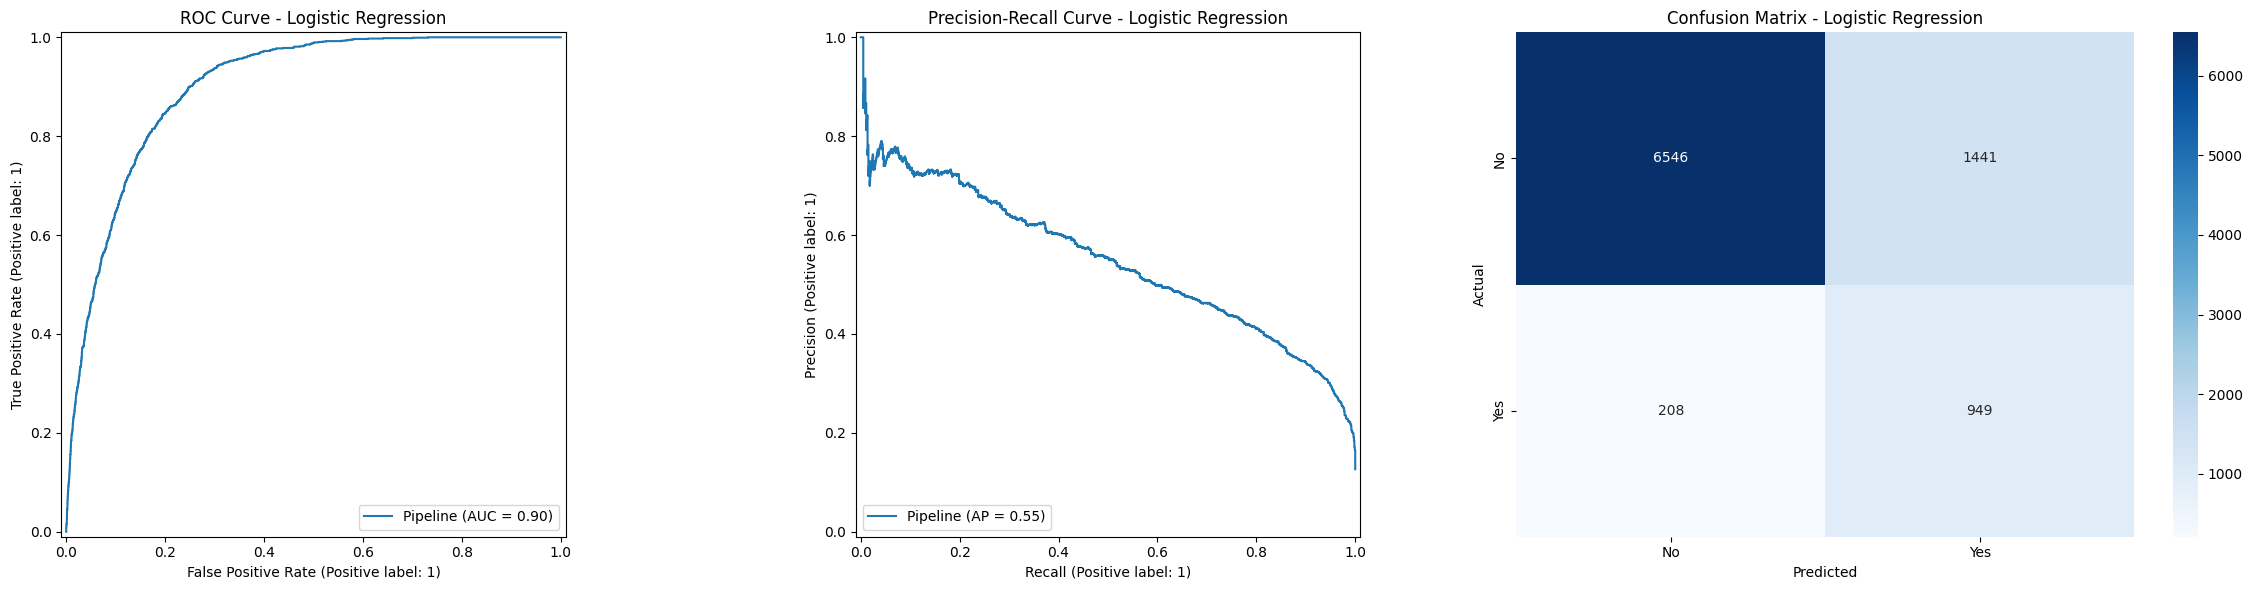

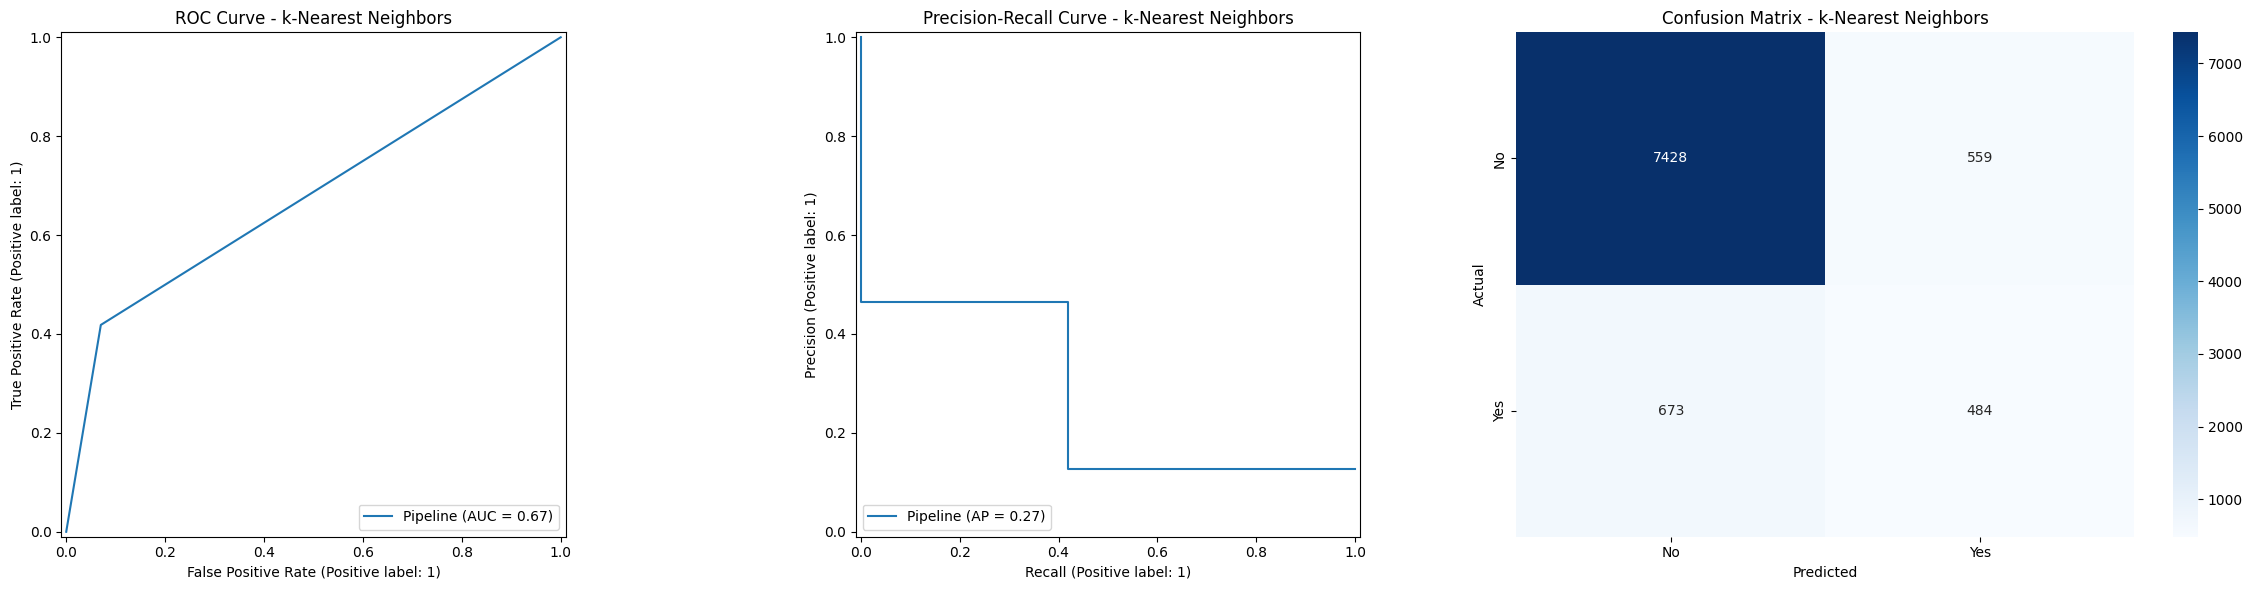

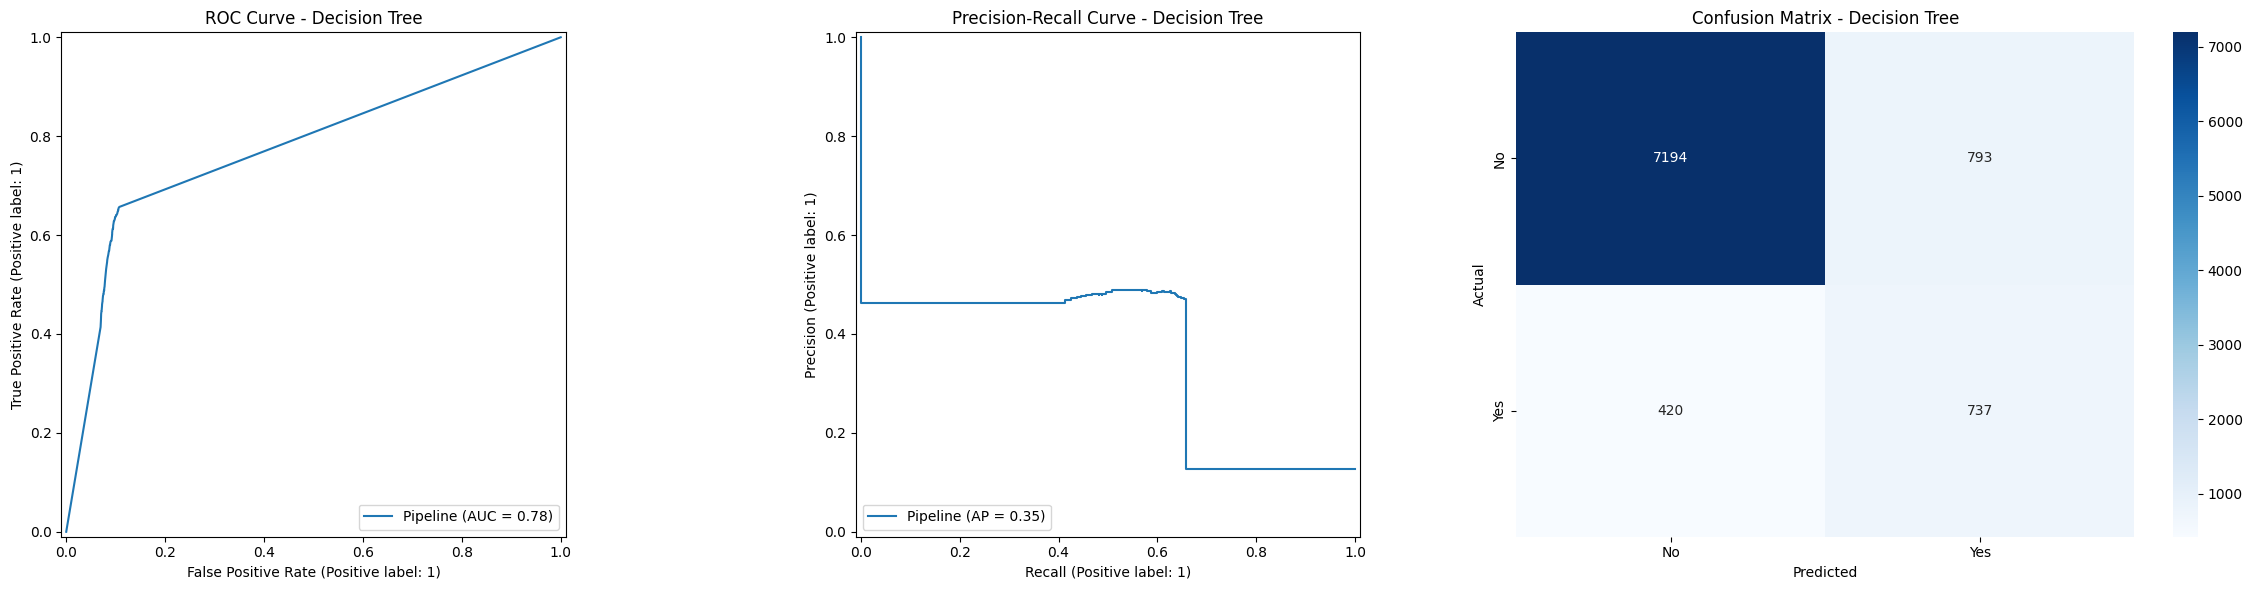

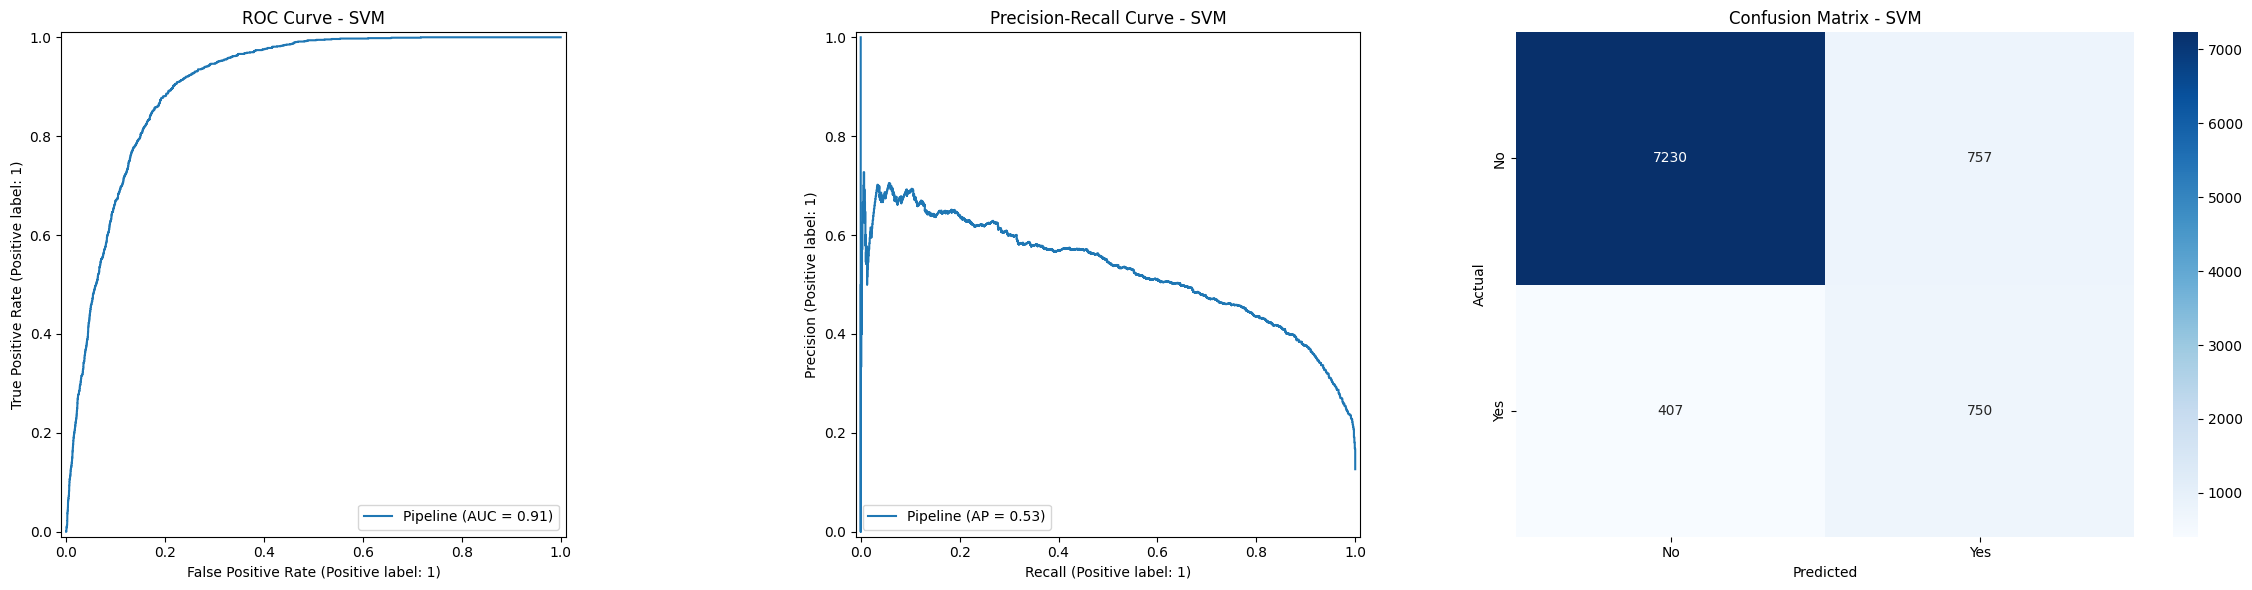

In [36]:
# Generate visualizations for each best model
for model_name, model_info in best_estimators.items():
    best_model = model_info['best_estimator']
    test_pred = best_model.predict(X_test)
    
    fig, ax = plt.subplots(1, 3, figsize=(24, 6))

    # ROC Curve
    roc_display = RocCurveDisplay.from_estimator(best_model, X_test, y_test, ax=ax[0])
    roc_display.ax_.set_title(f'ROC Curve - {model_name}')

    # Precision-Recall Curve
    pr_display = PrecisionRecallDisplay.from_estimator(best_model, X_test, y_test, ax=ax[1])
    pr_display.ax_.set_title(f'Precision-Recall Curve - {model_name}')

    # Confusion Matrix Heatmap
    conf_matrix = confusion_matrix(y_test, test_pred)
    conf_matrix_df = pd.DataFrame(conf_matrix, index=['No', 'Yes'], columns=['No', 'Yes'])
    sns.heatmap(conf_matrix_df, annot=True, fmt='d', cmap='Blues', ax=ax[2])
    ax[2].set_title(f'Confusion Matrix - {model_name}')
    ax[2].set_xlabel('Predicted')
    ax[2].set_ylabel('Actual')

    plt.tight_layout()
    plt.show()

### **Analysis of Logistic Regression Charts** ###

The charts provide comprehensive insights into the logistic regression model's performance:

**ROC Curve:**

<u>AUC (Area Under the Curve): 0.90</u>

This high AUC value indicates that the Logistic Regression model has a good measure of separability. It means the model is very effective in distinguishing between the positive and negative classes.

<u>Interpretation:</u>
The ROC curve plots the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. The closer the curve follows the left-hand border and the top border of the ROC space, the more accurate the test.

</br>

**Precision-Recall Curve:**

<u>AP (Average Precision): 0.55</u>

The AP score of 0.55 indicates moderate performance in terms of precision and recall trade-offs. Precision decreases as recall increases, showing that the model struggles with maintaining high precision at higher recall values.

<u>Interpretation:</u>
This curve is useful for evaluating the performance of the model on the minority class. The decline in precision with increasing recall highlights the challenge of achieving both high precision and high recall.

</br>

**Confusion Matrix:**

<u>True Negatives (TN):</u> 6546

<u>False Positives (FP):</u> 1441

<u>False Negatives (FN):</u> 208

<u>True Positives (TP):</u> 949

The confusion matrix shows that the model correctly predicts the majority class (No) much more often than the minority class (Yes).

<u>Interpretation:</u>
The model has a high number of true negatives, indicating it is effective at identifying negative cases. However, it also has a substantial number of false positives, which could be a concern in a business context where false positives might have costs.

</br>

**Best Parameters**

<u>C (Regularization Strength):</u> 10

<u>Penalty:</u> l2

<u>Solver:</u> liblinear

These parameters indicate that a higher regularization strength and the l2 penalty with the liblinear solver provide the best performance for the Logistic Regression model.

</br>

**Summary**
+ The Logistic Regression model, with its AUC of 0.90, demonstrates strong overall performance in distinguishing between classes.
+ The Precision-Recall curve highlights the challenge in balancing precision and recall, with moderate average precision.
+ The confusion matrix indicates that while the model is good at predicting the negative class, there is room for improvement in predicting the positive class to reduce false positives and false negatives.


### **Analysis of kNN Charts** ###


The charts provide comprehensive insights into the kNN model's performance

**ROC Curve:**

<u>AUC (Area Under the Curve):</u> 0.67

The AUC value of 0.67 indicates moderate performance. It shows that the k-NN model can distinguish between the positive and negative classes better than random guessing but not as effectively as other models.

<u>Interpretation:</u>
The ROC curve plots the true positive rate (TPR) against the false positive rate (FPR) at various threshold settings. The curve closer to the diagonal line indicates lower performance.

</br>

**Precision-Recall Curve:**

<u>AP (Average Precision):</u> 0.27

The average precision score of 0.27 suggests that the k-NN model struggles with maintaining precision as recall increases. This indicates that the model has difficulty in correctly identifying the positive class without also including many false positives.

<u>Interpretation:</u>
This curve is useful for evaluating the performance of the model on the minority class. The steep drop in precision with increasing recall highlights the challenge in achieving high precision for the positive class.

</br>

**Confusion Matrix:**

<u>True Negatives (TN):</u> 7428

<u>False Positives (FP):</u> 559

<u>False Negatives (FN):</u> 673

<u>True Positives (TP):</u> 484

The confusion matrix shows that the model correctly predicts the majority class (No) much more often than the minority class (Yes).

<u>Interpretation:</u>
The model has a high number of true negatives, indicating effectiveness at identifying negative cases. However, the substantial number of false negatives suggests that the model struggles significantly to correctly identify the positive class.

</br>

**Best Parameters**

<u>Metric:</u> Manhattan

<u>Number of Neighbors:</u> 1

<u>Weights:</u> Uniform

These parameters indicate that the best performance for the k-NN model is achieved using the Manhattan distance metric, with 1 neighbor and uniform weights, suggesting the importance of considering all points equally and using distance metrics effectively.

</br>

**Summary**
+ The k-NN model has moderate overall performance, with an AUC of 0.67 and average precision of 0.27, indicating challenges in distinguishing the positive class.
+ The Precision-Recall curve shows the difficulty in maintaining precision with increasing recall.
+ The confusion matrix highlights that while the model is effective at predicting the negative class, it struggles with the positive class, resulting in a high number of false negatives and false positives.

### **Analysis of Decision Tree Charts** ###


The charts provide comprehensive insights into the kNN model's performance

**ROC Curve:**

<u>AUC (Area Under the Curve):</u> 0.78

An AUC of 0.78 indicates that the Decision Tree model performs moderately well at distinguishing between the positive and negative classes.

<u>Interpretation:</u> The ROC curve shows the trade-off between true positive rate (sensitivity) and false positive rate (1-specificity). The closer the curve is to the top-left corner, the better the model is at distinguishing between classes.

</br>

**Precision-Recall Curve:**

<u>AP (Average Precision):</u> 0.35

The average precision score of 0.35 suggests that the model's ability to identify positive cases is moderate, with precision decreasing as recall increases.

<u>Interpretation:</u> The Precision-Recall curve highlights the model's performance on the minority class (positive class). The relatively flat precision-recall curve indicates that the model has a moderate precision for varying levels of recall.

</br>

**Confusion Matrix:**

<u>True Negatives (TN):</u> 7194

<u>False Positives (FP):</u> 793

<u>False Negatives (FN):</u> 420

<u>True Positives (TP):</u> 737

The confusion matrix indicates that the model correctly identifies the majority class (No) more often than the minority class (Yes).

<u>Interpretation:</u> The Decision Tree model shows a higher number of true negatives compared to true positives, which indicates that it is better at predicting the negative class. The significant number of false positives and false negatives suggests that the model has room for improvement in distinguishing between the classes.

</br>

**Best Parameters**

<u>Max Depth:</u> 20

<u>Min Samples Split:</u> 2

<u>Min Samples Leaf:</u> 1

These parameters indicate that the best performance for the Decision Tree model is achieved with a maximum tree depth of 20, a minimum of 2 samples required to split an internal node, and a minimum of 1 sample required to be at a leaf node, suggesting the importance of deeper trees and minimal constraints on leaf size for better performance.

</br>

**Summary**

+ The Decision Tree model demonstrates moderate overall performance with an AUC of 0.78 and average precision of 0.35, indicating that it is better at identifying the negative class than the positive class.
+ The Precision-Recall curve reveals challenges in maintaining high precision as recall increases.
+ The confusion matrix shows that the model is effective at predicting the negative class but struggles with the positive class, resulting in a higher number of false negatives and false positives.

### **Analysis of SVM Charts** ###


**ROC Curve:**

<u>AUC (Area Under the Curve):</u> 0.91

An AUC of 0.91 indicates that the SVM model performs very well at distinguishing between the positive and negative classes.

<u>Interpretation:</u>
The ROC curve shows the trade-off between the true positive rate (sensitivity) and false positive rate (1-specificity). The curve's proximity to the top-left corner indicates strong performance.

</br>

**Precision-Recall Curve:**

<u>AP (Average Precision):</u> 0.53

The average precision score of 0.53 suggests that the model has a good balance between precision and recall for the positive class.

<u>Interpretation:</u>
The Precision-Recall curve highlights the model's performance on the minority class (positive class). A higher AP score indicates better performance in identifying positive cases.

</br>

**Confusion Matrix:**

<u>True Negatives (TN):</u> 7230

<u>False Positives (FP):</u> 757

<u>False Negatives (FN):</u> 407

<u>True Positives (TP):</u> 750

The confusion matrix indicates that the model correctly identifies the majority class (No) more frequently than the minority class (Yes).

<u>Interpretation:</u>
The SVM model shows a higher number of true negatives compared to true positives, indicating better performance in predicting the negative class. The number of false positives and false negatives is relatively balanced, showing a more equitable treatment of both classes compared to other models.

</br>

**Best Parameters**

<u>C:</u> 200

<u>Kernel:</u> RBF (Radial Basis Function)

These parameters suggest that the best performance for the SVM model is achieved with a higher penalty for misclassification (C=200) and using the RBF kernel, which is effective for non-linear classification tasks.

</br>

**Summary**
+ The SVM model demonstrates strong overall performance with an AUC of 0.91 and an average precision of 0.53, indicating it is effective at distinguishing between classes.
+ The Precision-Recall curve reveals a good balance between precision and recall, particularly for the minority class.
+ The confusion matrix shows that the model is effective at predicting both classes, with relatively balanced false positives and false negatives.


### **Extract and visualize the feature importances - Logistic Regression, KNN, Decision Tree, and SVM models**

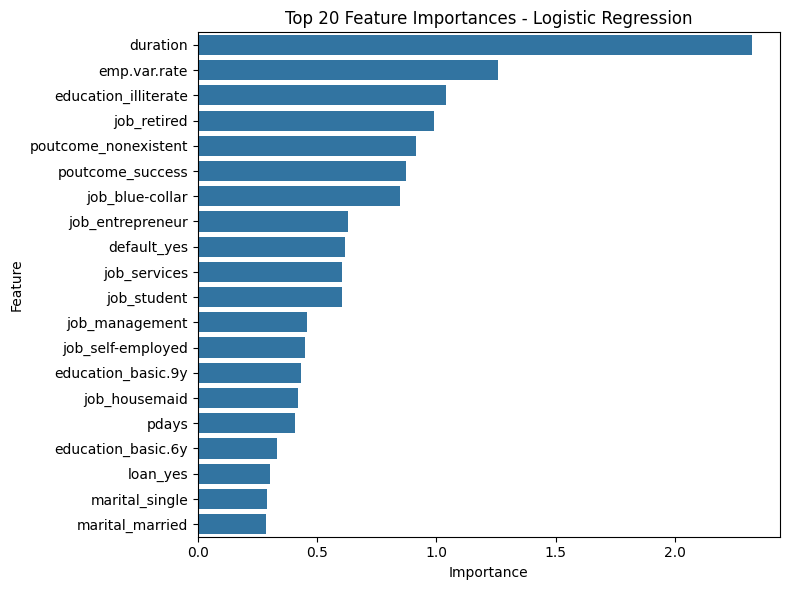

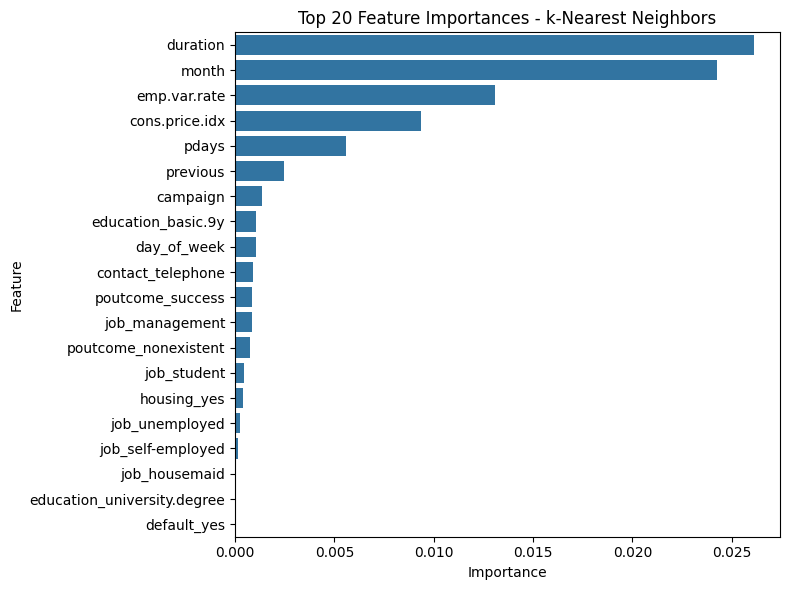

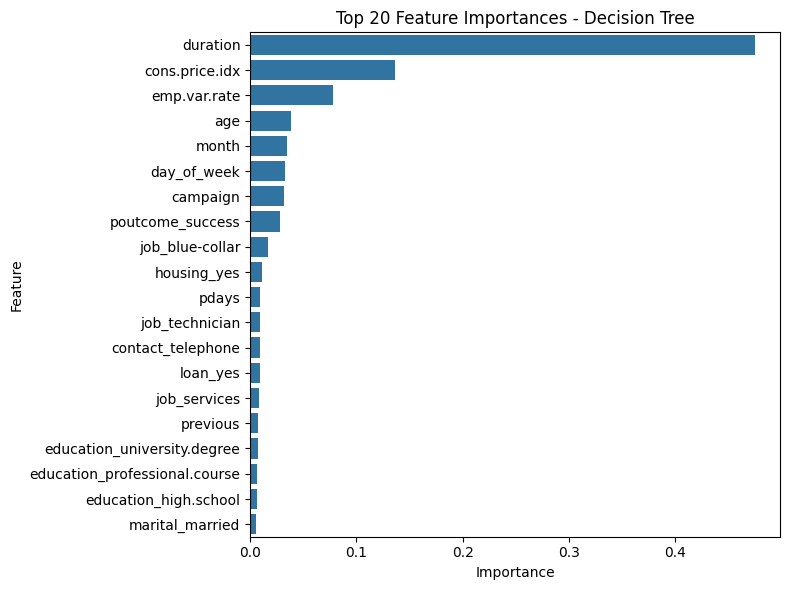

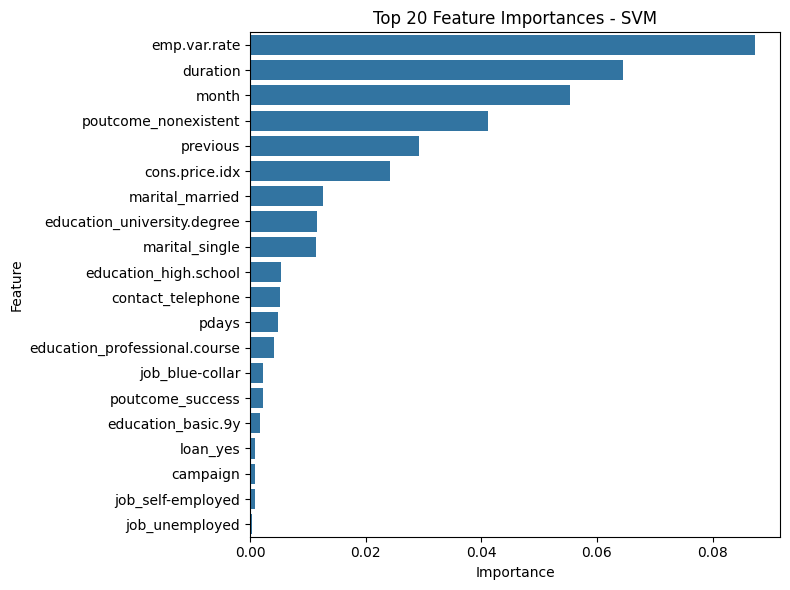

In [37]:
# Generate visualizations for each best model
for model_name, model_info in best_estimators.items():
    best_model = model_info['best_estimator']
    test_pred = best_model.predict(X_test)
    
    fig, ax = plt.subplots(1, 1, figsize=(8, 6))

    # Feature Importance
    if model_name == 'Logistic Regression':
        importances = np.abs(best_model.named_steps['classifier'].coef_[0])
    elif model_name == 'Decision Tree':
        importances = best_model.named_steps['classifier'].feature_importances_
    elif model_name == 'SVM' and best_model.named_steps['classifier'].kernel == 'linear':
        importances = np.abs(best_model.named_steps['classifier'].coef_[0])
    else:
        result = permutation_importance(best_model, X_test, y_test, n_repeats=10, random_state=42, n_jobs=-1)
        importances = result.importances_mean
    
    indices = np.argsort(importances)[::-1]
    feature_importance_df = pd.DataFrame({
        'Feature': np.array(all_features)[indices],
        'Importance': importances[indices]
    }).head(20)  # Display only the top 20 features

    sns.barplot(y='Feature', x='Importance', data=feature_importance_df, ax=ax)
    ax.set_title(f'Top 20 Feature Importances - {model_name}')
    ax.set_xlabel('Importance')
    ax.set_ylabel('Feature')

    plt.tight_layout()
    plt.show()

### **Insights into the Feature Importance - Logistic Regression** ###

**Duration:** This is the most significant feature, indicating that the length of the previous call plays a crucial role in determining the likelihood of a positive outcome.

**Employment Variation Rate (emp.var.rate):** This feature is also highly influential, suggesting that changes in employment rates significantly affect the target variable.


**Education Level:**

<u>Illiterate:</u> Higher importance, showing that education level can strongly influence the prediction.

<u>Basic (6y, 9y):</u> Less influential but still notable.

<u>University Degree:</u> Not in the top 20, implying less impact compared to other education levels.


**Job Role:**

<u>Retired, Blue-Collar, Entrepreneur:</u> These job categories are important predictors, reflecting different propensities towards the target outcome.

<u>Student, Housemaid, Self-employed:</u> These roles have moderate influence.


**Previous Outcome (poutcome):**

<u>Nonexistent and Success:</u> Both previous outcomes are significant, with 'nonexistent' slightly more influential.


**Other Socio-economic Factors:**

<u>Pdays:</u> The number of days since the client was last contacted is moderately important.

<u>Loan and Default:</u> Whether the client has a loan or default status also affects the prediction.


**Marital Status:**

<u>Single and Married:</u> Both statuses are included but have lower importance.

</br>

**Summary**

The logistic regression model highlights that the duration of the call, employment variation rate, and certain job roles are critical predictors. Socio-economic factors such as education, previous outcomes, and marital status also play a role but to a lesser extent. Understanding these feature importances can guide targeted marketing strategies and improve campaign effectiveness.

### **Insights into the Feature Importance - kNN** ###

**Duration:** This feature stands out as the most influential predictor, consistent with its importance in logistic regression. It indicates that the length of the previous call strongly affects the outcome.

**Month:** The month in which the contact was made is the second most important feature, suggesting that the timing within the year significantly influences the response.

**Employment Variation Rate (emp.var.rate):** This feature is crucial, implying that economic conditions, specifically changes in employment rates, impact the target variable.

**Consumer Price Index (cons.price.idx):** This indicates that broader economic factors like inflation rates also play a role in predicting outcomes.

**Pdays:** The number of days since the client was last contacted is moderately important, reflecting the recency effect.

**Previous:** The number of contacts performed before this campaign impacts the likelihood of a positive outcome.

**Campaign:** The number of contacts performed during this campaign is less influential but still notable.

**Education (basic.9y):** Education level, particularly basic education (9 years), also influences predictions.

**Day of Week:** The specific day of the week when the contact was made has a minor impact.


**Contact and Outcome Factors:**

<u>Telephone Contact:</u> The method of contact is slightly important.

<u>Previous Outcomes:</u> Success or nonexistence of previous outcomes impacts the prediction.


**Job Roles:** Management and student job roles show some influence.

**Housing and Employment Status:** These socio-economic factors, including whether the client has housing or is unemployed, play minor roles.

</br>

**Summary**

The k-Nearest Neighbors model highlights that duration, the month of contact, and economic indicators are the most critical predictors. Unlike logistic regression, the importance of the month and consumer price index is more pronounced. This model underscores the significance of both campaign-specific and broader economic features in predicting outcomes.

### **Insights into the Feature Importance - Decision Tree** ###

**Duration:** The most crucial feature by a significant margin, indicating that the length of the previous call has a dominant influence on the decision-making process.

**Consumer Price Index (cons.price.idx):** The second most important feature, reflecting the impact of economic conditions, specifically inflation rates, on the likelihood of a positive response.

**Employment Variation Rate (emp.var.rate):** This is another significant economic indicator affecting the outcome.

**Age:** The client's age is a notable factor, suggesting that age demographics play a role in the decision process.

**Month and Day of Week:** The timing of the contact within the year and the week influences the prediction, though to a lesser extent than the duration and economic indicators.

**Campaign:** The number of contacts performed during this campaign has a moderate impact on the outcome.

**Previous Outcome Success (poutcome_success):** The success of previous campaigns is an important predictor, indicating past behavior influences future decisions.

**Job Roles and Housing:** Certain job roles, like blue-collar and technician, along with housing status (whether the client has housing), are influential socio-economic factors.

**Pdays and Previous Contacts:** The number of days since the last contact and the number of previous contacts are less influential but still contribute to the model's decisions.

**Education Levels and Contact Method:** Various education levels and the method of contact (telephone) have minor influences.

</br>

**Summary**

The Decision Tree model emphasizes the importance of call duration and economic conditions (consumer price index and employment variation rate). Age, month, and day of the week also contribute, highlighting both demographic and timing factors. Previous campaign success and specific job roles further influence the decision-making process, while education and contact method play smaller roles. This model showcases a comprehensive approach, integrating call specifics, economic indicators, demographics, and past behaviors to predict outcomes.

### **Insights into the Feature Importance - SVM** ###

**Employment Variation Rate (emp.var.rate):** The most crucial feature, indicating that fluctuations in employment rates significantly impact the prediction outcomes.

**Duration:** The length of the previous call is a critical factor, demonstrating its strong influence on client response.

**Month:** The timing within the year significantly affects the prediction, highlighting seasonal trends or campaign-specific timings.

**Previous Campaign Outcome (poutcome_nonexistent):** The absence of previous campaign results is a notable factor, possibly indicating first-time contacts or missing historical data's impact.

**Previous Contacts:** The number of prior contacts with the client plays an essential role, reflecting the effect of repeated engagements.

**Consumer Price Index (cons.price.idx):** An important economic indicator influencing client behavior.

**Marital Status (married and single):** Both married and single status have notable importance, suggesting the socio-demographic factors influencing the prediction.

**Education Levels (university degree, high school, and professional course):** Various education levels impact the prediction, indicating that educational background influences client response.

**Contact Method (contact_telephone):** The method of contact (telephone) affects the prediction outcome.

**Pdays:** The number of days since the last contact influences the model, reflecting recency effects.

**Job Roles (blue-collar, self-employed, and unemployed):** Specific job roles impact the prediction, indicating socio-economic factors at play.

**Loan Status (loan_yes):** Whether the client has a loan influences the prediction.

**Campaign:** The number of contacts during the campaign has a minor yet notable impact.

</br>

**Summary**

The SVM model prioritizes economic indicators (employment variation rate and consumer price index) and call specifics (duration and month). Previous campaign outcomes and client demographics (marital status and education levels) also play significant roles. This comprehensive approach highlights the importance of economic conditions, call details, historical interactions, and socio-demographic factors in predicting client responses.

### **Executive Summary** ###

**Best Model: Support Vector Machine (SVM)**

**Performance Metrics:**

+ Accuracy: 87.3%

+ F1 Score: 56.3%

+ Area Under Curve (AUC): 0.91

+ Average Precision (AP): 0.53

</br>

**Insights:**

+ ROC Curve: The SVM model demonstrates a high AUC of 0.91, indicating strong overall performance in distinguishing between classes.

+ Precision-Recall Curve: The precision-recall curve shows an AP of 0.53, reflecting the model’s balanced handling of precision and recall for the positive class.

+ Confusion Matrix: The confusion matrix shows that the SVM model accurately predicted 7230 instances of the negative class and 757 of the positive class. However, there are still significant false negatives (407), which suggests room for improvement in recall.

</br>

**Best Parameters:**

+ C: 200

+ Kernel: RBF

</br>

**Comparison with Other Models:**

+ Logistic Regression: AUC of 0.90, AP of 0.55, accuracy of 82%, and F1 score of 53.5%.

+ Decision Tree: AUC of 0.78, AP of 0.35, accuracy of 86.7%, and F1 score of 54.9%.

+ k-Nearest Neighbors: AUC of 0.67, AP of 0.27, accuracy of 86.5%, and F1 score of 44%.

</br>

**Conclusion:**
The SVM model outperformed other models in terms of accuracy, F1 score, and AUC, making it the best choice for the given dataset. Its high precision and recall balance ensure reliable performance in predicting the positive class, despite some false negatives. The model's robustness is attributed to the optimized parameters, demonstrating the efficacy of SVM with RBF kernel in handling the complexity of the data.